## Setup

In [1]:
from IPython import get_ipython # type: ignore
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Standard imports
import os
import torch
import numpy as np
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import einops
from jaxtyping import Float, Int
from torch import Tensor

torch.set_grad_enabled(False)

# Device setup
GPU_TO_USE = 3

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = f"cuda:{GPU_TO_USE}" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# utility to clear variables out of the memory & and clearing cuda cache
import gc
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

Device: cuda:3


In [2]:
from pathlib import Path
import sys
import os

def get_base_folder(project_root = "tim-taras-sfc-errors"):
	# Find the project root dynamically
	current_dir = os.getcwd()
	while True:
		if os.path.basename(current_dir) == project_root:  # Adjust to match your project root folder name
			break
		parent = os.path.dirname(current_dir)
		if parent == current_dir:  # Stop if we reach the system root (failsafe)
			raise RuntimeError(f"Project root {project_root} not found. Check your folder structure.")
		current_dir = parent

	return current_dir

def get_project_folder(base_folder=None, project_folder_name='sfc-errors'):
	if base_folder is None:
		base_folder = get_base_folder()
	
	return Path(base_folder) / project_folder_name

def get_data_path(base_folder=None, data_folder_name='data'):
	if base_folder is None:
		base_folder = get_base_folder()

	return Path(base_folder) / data_folder_name

In [3]:
base_path = get_base_folder()
print(f"Base path: {base_path}")

project_path = get_project_folder(base_folder=base_path)
print(f"Project path: {project_path}")

sys.path.append(base_path)
sys.path.append(str(project_path))

Base path: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors
Project path: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/sfc-errors


In [4]:
datapath = get_data_path(base_path) 
datapath

PosixPath('/mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data')

In [5]:
# Additionally, setup the logging file so that we can track the output even when disconnected from the front-end Jupyter interface
import sys
import logging

nblog = open("nb.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


## Loading the model

We'll work with Gemma-2 2B (base version)

In [6]:
from sae_lens import HookedSAETransformer

USE_INSTRUCT = False
PARAMS_COUNT = 2

MODEL_NAME = f'gemma-2-{PARAMS_COUNT}b' + ('-it' if USE_INSTRUCT else '')
print(f'Using {MODEL_NAME}')

model = HookedSAETransformer.from_pretrained(MODEL_NAME, device=device, dtype=torch.bfloat16)
model

Using gemma-2-2b


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


HookedSAETransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-25): 26 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln1_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
      

## Loading the data

This uses my custom dataloader class, which parses raw data and prepares into a nice format for SFC, including providing some useful metadata such as token positions for where the answer should be, attention masks etc. The details of the class are convoluted because it was developed for a more general purpose than verb agreement tasks, so you can largely ignore the next few cells.

In [7]:
from classes.sfc_data_loader import SFCDatasetLoader
import utils.prompts as prompts
from utils.enums import *

In [8]:
# Load one of the supported dataset
DATASET_NAME = SupportedDatasets.VERB_AGREEMENT_TEST_CONFIDENT_MODEL

dataloader = SFCDatasetLoader(DATASET_NAME, model,
                              local_dataset=True, base_folder_path=datapath)
# Define the experiment directory where we'll save our data
EXPERIMENT = 'sva_rc_filtered'
saving_dir = datapath / EXPERIMENT

print(f'Using {DATASET_NAME} dataset and saving to the dir data/{EXPERIMENT}.')

Using SupportedDatasets.VERB_AGREEMENT_TEST_CONFIDENT_MODEL dataset and saving to the dir data/sva_rc_filtered.


Below we'll parse the dataset into SFC-friendly format. `USE_SINGLE_DATASET` var below indicated whether to use a single dataset with no clean & patched dataset separation, or to use the original datasets from the SFC paper where we separate between clean & patched prompts for computing AtP/IG scores.

In [9]:
USE_SINGLE_DATASET = DATASET_NAME.value in [SupportedDatasets.VERB_AGREEMENT_TEST_CONFIDENT_MODEL.value, SupportedDatasets.VERB_AGREEMENT_TEST_CONFIDENT_MODEL_SALIENT_CIRCUIT.value]

if USE_SINGLE_DATASET:
    dataset = dataloader.get_single_dataset(tokenize=True, apply_chat_template=False, prepend_generation_prefix=True)
else:
    clean_dataset, corrupted_dataset = dataloader.get_clean_corrupted_datasets(tokenize=True, apply_chat_template=False, prepend_generation_prefix=True)

Dataset SupportedDatasets.VERB_AGREEMENT_TEST_CONFIDENT_MODEL has constant length prompts. Skipping padding calculation.


100%|██████████| 16433/16433 [00:14<00:00, 1149.62it/s]


Corrupted dataset here refers to the collection of patched prompts and their answers (verb completions) in the SFC paper terminology. It can be absent if we're a single dataset, which is why we write the cell below

In [10]:
if USE_SINGLE_DATASET:
    clean_dataset = dataset
    # we'll need to pass corrupted dataset as None to our main 
    # CircuitEvaluator.evaluate_circuit_faithfulness method below
    corrupted_dataset = None

    print(dataset)

{'prompt': tensor([[     2,    651,  28219,  ...,    573,  61248,  23030],
        [     2,    651,  47189,  ...,    573,  19507,  88111],
        [     2,    651,   5842,  ...,    573,  58348,  12637],
        ...,
        [     2,    651,  28219,  ...,    573, 218332,   8590],
        [     2,    651,   9382,  ...,    573,  14364,  44434],
        [     2,    651,    916,  ...,    573,  10981,  20635]],
       device='cuda:3'), 'true_answer': tensor([ 791,  603, 6128,  ...,  871,  603, 1721], device='cuda:3'), 'false_answer': tensor([ 919,  708,  871,  ..., 6128,  708,  749], device='cuda:3'), 'answer_pos': tensor([6, 6, 6,  ..., 6, 6, 6], device='cuda:3'), 'special_token_mask': tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:3'), 'control_sequence_length': tensor([2, 2, 2,  ..., 2, 2, 2], device='cuda:3

In [11]:
CONTROL_SEQ_LEN = clean_dataset['control_sequence_length'][0].item() # how many first tokens to ignore when computing SFC scores
N_CONTEXT = clean_dataset['prompt'].shape[1]

CONTROL_SEQ_LEN, N_CONTEXT

(2, 7)

In [12]:
print('Clean dataset:')
for prompt in clean_dataset['prompt'][:3]:
  print("\nPrompt:", model.to_string(prompt), end='\n\n')

  for i, tok in enumerate(prompt):
    str_token = model.to_string(tok)
    print(f"({i-CONTROL_SEQ_LEN}, {str_token})", end=' ')
  print()

if not USE_SINGLE_DATASET:
    print('Corrupted dataset:')
    for prompt in corrupted_dataset['prompt'][:3]:
      print("\nPrompt:", model.to_string(prompt), end='\n\n')
      
      for i, tok in enumerate(prompt):
        str_token = model.to_string(tok)
        print(f"({i-CONTROL_SEQ_LEN}, {str_token})", end=' ')
      print()

Clean dataset:

Prompt: <bos>The mothers that the dancers praise

(-2, <bos>) (-1, The) (0,  mothers) (1,  that) (2,  the) (3,  dancers) (4,  praise) 

Prompt: <bos>The aunt that the architect praises

(-2, <bos>) (-1, The) (0,  aunt) (1,  that) (2,  the) (3,  architect) (4,  praises) 

Prompt: <bos>The father that the assistants describe

(-2, <bos>) (-1, The) (0,  father) (1,  that) (2,  the) (3,  assistants) (4,  describe) 


In [13]:
# Sanity checks
if not USE_SINGLE_DATASET:
    # Control sequence length must be the same for all samples in both datasets
    clean_ds_control_len = clean_dataset['control_sequence_length']
    corrupted_ds_control_len = corrupted_dataset['control_sequence_length']
    
    assert torch.all(corrupted_ds_control_len == corrupted_ds_control_len[0]), "Control sequence length is not the same for all samples in the dataset"
    assert torch.all(clean_ds_control_len == clean_ds_control_len[0]), "Control sequence length is not the same for all samples in the dataset"
    assert clean_ds_control_len[0] == corrupted_ds_control_len[0], "Control sequence length is not the same for clean and corrupted samples in the dataset"
else:
    assert dataset['true_answer'].max().item() < model.cfg.d_vocab, "Patched answers exceed vocab size"
    assert dataset['false_answer'].max().item() < model.cfg.d_vocab, "Patched answers exceed vocab size"
    assert (dataset['answer_pos'] < N_CONTEXT).all().item(), "Answer positions exceed logits length"

# Setting up the SAEs

In [14]:
from classes.sfc_model import SFC_Gemma

RUN_WITH_SAES = True # we'll need to run the model with attached SAEs

# Determine the caching device, where we'll load our SAEs and compute the SFC scores
if RUN_WITH_SAES:
    caching_device = device 
else:
    caching_device = "cuda:0"


caching_device

'cuda:3'

For replicating the SFC part from the paper I used my custom SFC_Gemma class. In short, it
- Loads a Gemma model and its Gemma Scope SAEs (either attaching them to the model or not)
- Provides interface methods to compute SFC scores (currently, only attr patching is supported) on an arbitrary dataset (that follows the format of my SFCDatasetLoader class from above)

In [15]:
clear_cache()
sfc_model = SFC_Gemma(model, params_count=PARAMS_COUNT, control_seq_len=CONTROL_SEQ_LEN, 
                      attach_saes=RUN_WITH_SAES, caching_device=caching_device,
                      data_dir=datapath, experiment_name=EXPERIMENT)
clear_cache()

# sfc_model.print_saes()
# sfc_model.model.cfg
# , sfc_model.saes[0].cfg.dtype

Using 16K SAEs for the first 26 layers, the rest 0 layer(s) - 131k SAEs
Loaded SFC scores from /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data/sva_rc_filtered/sfc_scores.pkl
Loaded mean activations from /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data/sva_rc_filtered/mean_activations.pkl


# Main part

Here we'll call use CircuitEvaluator class, which encapsulates the SFC circuit evaluation logic, as well as ablation & restoration functionality.

In [16]:
from classes.sfc_evaluator import CircuitEvaluator

circuit_evaluator = CircuitEvaluator(sfc_model)

In [17]:
# Define utilities for displaying the features we'll select to restore
def display_selected_features(selected_nodes_info, sfc_node_scores, 
                              abs_scores=False, print_k_positions=10):
    """
    Display the selected nodes and their features in a readable format
    
    Args:
        selected_nodes_info: Tuple containing (feature_indices_dict, maximizing_positions_dict)
        sfc_node_scores: SFC_NodeScores object containing the node scores
        abs_scores: Whether to use absolute values when displaying scores
    """
    feature_indices_dict, maximizing_positions_dict = selected_nodes_info
    
    print(f"Selected features from {len(feature_indices_dict)} activations in total")
    
    for node_name, indices in feature_indices_dict.items():
        # Get maximizing positions for this node
        max_positions = maximizing_positions_dict[node_name]
        
        # Display the node with its indices
        print(f"\n• {node_name} ({len(indices)} features):")
        
        # If there are many indices, display them in a compact way
        if len(indices) > 10:
            # Show first 5 and last 5 with ellipsis in between
            indices_display = f"{indices[:5]} ... {indices[-5:]}"
        else:
            indices_display = str(indices)
        
        print(f"  Indices: {indices_display}")
        
        # Get the actual scores for these indices to show their importance
        node_scores = sfc_node_scores.node_scores[node_name]
        
        if node_scores.dim() > 1:  # SAE feature node
            # Print histogram of maximizing positions
            position_counts = {}
            for pos in max_positions.cpu().numpy():
                position_counts[int(pos)] = position_counts.get(int(pos), 0) + 1
            
            print("  Maximizing positions distribution:")
            for pos, count in sorted(position_counts.items()):
                percentage = 100 * count / len(indices)
                print(f"    Position {pos}: {count} features ({percentage:.1f}%)")
            
            # Display sample feature-position mappings
            sample_size = min(print_k_positions, len(indices))
            if sample_size > 0:
                print("\n  Sample features and their maximizing positions:")
                for i in range(sample_size):
                    feat_idx = indices[i] if isinstance(indices, list) else indices.tolist()[i]
                    pos = max_positions[i].item()
                    
                    # Get the score at the maximizing position
                    if abs_scores:
                        score = abs(node_scores[pos, feat_idx].item())
                    else:
                        score = node_scores[pos, feat_idx].item()
                    
                    print(f"    Feature {feat_idx}: position {pos}, score {score:.6f}")

def display_neuronpedia_features(selected_nodes_info, model_name='gemma-2-2b', max_features_per_type=3, 
                                 sfc_node_scores=None, abs_scores=False):
    """
    Display selected SAE features using Neuronpedia visualizations
    
    Args:
        selected_nodes_info: Tuple containing (feature_indices_dict, maximizing_positions_dict)
        model_name: Name of the model in Neuronpedia
        max_features_per_type: Maximum number of features to display per type
        sfc_node_scores: SFC_NodeScores object for scoring features (required for score-based selection)
        abs_scores: Whether to use absolute scores
    """
    from IPython.display import IFrame, display
    
    feature_indices_dict, maximizing_positions_dict = selected_nodes_info
    html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"
    
    # Collect features by type with their scores
    resid_features = []
    mlp_features = []
    attn_features = []
    
    for node_name, indices in feature_indices_dict.items():
        # Extract layer number from node name
        layer_num = int(node_name.split('.')[1])
        
        # Get maximizing positions
        max_positions = maximizing_positions_dict[node_name]
        
        # Get feature scores if sfc_node_scores is provided
        if sfc_node_scores is not None:
            node_scores = sfc_node_scores.node_scores[node_name]
            
            # Extract scores for these indices at their maximizing positions
            feature_scores = []
            for i, idx in enumerate(indices if isinstance(indices, list) else indices.tolist()):
                max_pos = max_positions[i].item()
                score = node_scores[max_pos, idx].item()
                if abs_scores:
                    score = abs(score)
                feature_scores.append(score)
        else:
            # Default scores to placeholder values if not provided, assuming indices are already sorted by importance
            feature_scores = [len(indices) - i for i in range(len(indices))]
        
        # Determine component type
        if 'hook_resid_post' in node_name:
            component_type = 'resid'
            features = resid_features
            sae_width = '16k'
        elif 'hook_mlp_out' in node_name:
            component_type = 'mlp'
            features = mlp_features
            sae_width = '16k'
        elif 'attn.hook_z' in node_name:
            component_type = 'attn'
            features = attn_features
            sae_width = '16k'
        else:
            continue  # Skip unknown component types
        
        # Add features with their maximizing positions and scores
        for i, idx in enumerate(indices if isinstance(indices, list) else indices.tolist()):
            max_pos = max_positions[i].item()
            score = feature_scores[i]
            features.append((layer_num, idx, max_pos, sae_width, score))
    
    # Display residual features (sorted by score)
    if resid_features:
        # Sort by score (highest first)
        resid_features.sort(key=lambda x: x[4], reverse=True)
        
        print(f"\n{'='*80}\nRESIDUAL STREAM FEATURES (Top {min(max_features_per_type, len(resid_features))} by score)\n{'='*80}")
        for i, (layer, idx, max_pos, sae_width, score) in enumerate(resid_features[:max_features_per_type]):
            print(f"\nFeature {i+1}/{min(max_features_per_type, len(resid_features))}")
            print(f"Layer: {layer}, Feature: {idx}, Maximizing Position: {max_pos}, Score: {score:.6f}")
            
            # Generate Neuronpedia URL
            sae_release = f'{layer}-gemmascope-res-{sae_width}'
            url = html_template.format(model_name, sae_release, idx)
            link_without_query = url.split('?')[0]
            
            print('Link:', link_without_query)
            display(IFrame(url, width=1200, height=400))
    
    # Display MLP features (sorted by score)
    if mlp_features:
        # Sort by score (highest first)
        mlp_features.sort(key=lambda x: x[4], reverse=True)
        
        print(f"\n{'='*80}\nMLP FEATURES (Top {min(max_features_per_type, len(mlp_features))} by score)\n{'='*80}")
        for i, (layer, idx, max_pos, sae_width, score) in enumerate(mlp_features[:max_features_per_type]):
            print(f"\nFeature {i+1}/{min(max_features_per_type, len(mlp_features))}")
            print(f"Layer: {layer}, Feature: {idx}, Maximizing Position: {max_pos}, Score: {score:.6f}")
            
            # Generate Neuronpedia URL
            sae_release = f'{layer}-gemmascope-mlp-{sae_width}'
            url = html_template.format(model_name, sae_release, idx)
            link_without_query = url.split('?')[0]
            
            print('Link:', link_without_query)
            display(IFrame(url, width=1200, height=400))
    
    # For attention features (no visualization available yet)
    if attn_features:
        # Sort by score (highest first)
        attn_features.sort(key=lambda x: x[4], reverse=True)
        
        print(f"\n{'='*80}\nATTENTION FEATURES (Top {min(max_features_per_type, len(attn_features))} by score)\n{'='*80}")
        for i, (layer, idx, max_pos, _, score) in enumerate(attn_features[:max_features_per_type]):
            print(f"Layer: {layer}, Feature: {idx}, Maximizing Position: {max_pos}, Score: {score:.6f}")
            print("No Neuronpedia visualization available for attention features")

## Defining the set of SAE latents to restore

Here we'll inspect the features we'll be restoring in the code. Restoring means:
- Patching in original activations from unaffected pass (w/o ablations), into the forward pass that is affected by ablations.
- i.e. patching in feature activations as they would have been without any ablations

In [48]:
# utility to generate feature restoration ranges
def generate_jagged_layer_list(start: int, end: int) -> list[list[int]]:
    """
    Generate a jagged nested list from [start, ..., end], 
    removing one item from the end in each subsequent list.

    Example:
        generate_jagged_layer_list(18, 25) returns:
        [
            [18, 19, 20, 21, 22, 23, 24, 25],
            [18, 19, 20, 21, 22, 23, 24],
            ...
            [18]
        ]
    """
    return [list(range(start, end - i + 1)) for i in range(end - start + 1)]

# Define the set of layers where we'll restore the features from
layers_to_extract = generate_jagged_layer_list(16, 22)
print(layers_to_extract)

top_k_counts = [1, 3, 5, 10, 25, 50, 100]
positions_to_select = [6]  # Only restore features at these token positions - same positions where we'll ablate the error nodes

# Config to determine how we choose top-K features
extraction_params = {
    'abs_scores': False, # Whether to use absolute values of scores when selecting top-K features.
    'aggregation_type': 'max', # within the given positions, how do we aggregate the features AtP score
    'positions_to_select': positions_to_select, # positions we select Top-K features from
    'include_components': [ # what type of features we select
                           'hook_resid_post', 
                           # 'attn.hook_z', 
                           # 'hook_mlp_out',
                          ]
}

[[16, 17, 18, 19, 20, 21, 22], [16, 17, 18, 19, 20, 21], [16, 17, 18, 19, 20], [16, 17, 18, 19], [16, 17, 18], [16, 17], [16]]


In [19]:
# Store aggregation settings for consistent display
abs_scores = extraction_params['abs_scores']

for layer_idx, layer in enumerate(layers_to_extract):
    print(f"\n{'='*80}\nLAYER {layer}\n{'='*80}")
    
    for top_k_value in top_k_counts:
        print(f"\n{'-'*60}\nTop {top_k_value} features\n{'-'*60}")
        
        # Extract just this layer with the specified top_k value
        selected_nodes_info = circuit_evaluator.sfc_node_scores.get_top_k_features_by_layer(
            layer, 
            top_k_counts=top_k_value,
            verbose=False,  # Turn off built-in verbose output for cleaner display
            **extraction_params
        )
        
        # Display the selected nodes with their maximizing positions
        display_selected_features(selected_nodes_info, circuit_evaluator.sfc_node_scores, abs_scores, print_k_positions=0)
        
        # Optionally display Neuronpedia visualizations for top features by score
        # display_neuronpedia_features(
        #     selected_nodes_info, 
        #     max_features_per_type=3,
        #     sfc_node_scores=circuit_evaluator.sfc_node_scores,
        #     abs_scores=abs_scores
        # )


LAYER [16, 17, 18, 19, 20, 21, 22]

------------------------------------------------------------
Top 1 features
------------------------------------------------------------
Selected features from 7 activations in total

• blocks.16.hook_resid_post.hook_sae_acts_post (1 features):
  Indices: [14177]
  Maximizing positions distribution:
    Position 6: 1 features (100.0%)

• blocks.17.hook_resid_post.hook_sae_acts_post (1 features):
  Indices: [11590]
  Maximizing positions distribution:
    Position 6: 1 features (100.0%)

• blocks.18.hook_resid_post.hook_sae_acts_post (1 features):
  Indices: [10665]
  Maximizing positions distribution:
    Position 6: 1 features (100.0%)

• blocks.19.hook_resid_post.hook_sae_acts_post (1 features):
  Indices: [2211]
  Maximizing positions distribution:
    Position 6: 1 features (100.0%)

• blocks.20.hook_resid_post.hook_sae_acts_post (1 features):
  Indices: [301]
  Maximizing positions distribution:
    Position 6: 1 features (100.0%)

• blocks.21.

## Main ablation & restoration experiment (variable top-k)

First experiment of the Ablation & Restoration experiments section of the post: ablate all error nodes within the specified layers and `positions_to_select` (last position 6 by default), and restore SAE nodes from different layer ranges (and for different number of Top-K features to restore)

In [49]:
import pandas as pd
from collections import defaultdict

# ablate all resid error nodes up until (and including) this threshold 
ERRORS_LAYER_THRESHOLD_TOP = 23
ERRORS_LAYER_THRESHOLD_BOTTOM = 0

# Define error ablation function for this threshold
def ablate_error_hook(act_name):
    if 'hook_resid_post.hook_sae_error' not in act_name:
        return False
        
    # Split the input string by periods
    parts = act_name.split('.')
    error_layer_num = int(parts[1])
    
    return ERRORS_LAYER_THRESHOLD_BOTTOM <= error_layer_num <= ERRORS_LAYER_THRESHOLD_TOP

# Consult the CircuitEvaluator.evaluate_circuit_faithfulness() method documentation for the meaning of the params below
evaluation_params = {
    'cutoff_early_layers': False,
    'nodes_to_always_ablate': ablate_error_hook,
    'always_ablate_positions': positions_to_select,
    'return_all_metrics': True,
    # 'use_zero_ablation': True, # Uncomment if you want to run a zero ablation variant
    
    'batch_size': 1024,
    'total_batches': None,
    'verbose': True
}

# Initialize data collection structures
results = defaultdict(list)
detailed_results = {}  # For storing comprehensive data that doesn't fit in a dataframe

# Store aggregation settings for consistent display
abs_scores = extraction_params['abs_scores']

In [21]:
# Reset the hooks to avoid weird bugs
sfc_model.model.reset_hooks()
if RUN_WITH_SAES:
    sfc_model._reset_sae_hooks()
clear_cache()

In [ ]:
# Main loop
for layer_idx, layer in enumerate(layers_to_extract):
    print(f"\n{'='*80}\nLAYER {layer}\n{'='*80}")
    
    for top_k_value in top_k_counts:
        print(f"\n{'-'*60}\nTop {top_k_value} features\n{'-'*60}")
        
        # Create a unique key for this configuration
        config_key = f"layer_{layer}_top_{top_k_value}"
        
        # Select top-K features to restore
        selected_nodes_info = circuit_evaluator.sfc_node_scores.get_top_k_features_by_layer(
            layer, 
            top_k_counts=top_k_value,
            verbose=False,  # Turn off built-in verbose output for cleaner display
            **extraction_params
        )
        
        # Unpack the returned data
        feature_indices_dict, maximizing_positions_dict = selected_nodes_info
        
        # Save the detailed feature information
        detailed_results[config_key] = {
            'feature_indices': feature_indices_dict,
            'maximizing_positions': maximizing_positions_dict,
            'layer': layer,
            'top_k': top_k_value
        }
        
        # Display the selected nodes with their maximizing positions (optional)
        # display_selected_features(selected_nodes_info, circuit_evaluator.sfc_node_scores, abs_scores, print_k_positions=0)
        
        # Prepare nodes_to_restore and feature_indices_to_restore for circuit evaluation
        nodes_to_restore = list(feature_indices_dict.keys())  # All nodes with selected features
        
        # Evaluate circuit faithfulness
        faithfulness_metrics, n_nodes_in_circuit = circuit_evaluator.evaluate_circuit_faithfulness(
            clean_dataset=clean_dataset,
            patched_dataset=corrupted_dataset,
            # comment out these lines if you want to get the baseline faithfulness (without restoration)
            nodes_to_restore=nodes_to_restore,
            feature_indices_to_restore=feature_indices_dict,
            # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            return_all_metrics=True,
            **evaluation_params
        )
        
        # Before computing the mean and std metrics, filter out infs if there are any
        faithfulness_finite_mask = torch.isfinite(faithfulness_metrics)
        infinite_values_count = (~faithfulness_finite_mask).sum()
        if infinite_values_count > 0:
            print(f'Filtered out {infinite_values_count} infinite metrics')
        
        mean_faithfulness = faithfulness_metrics[faithfulness_finite_mask].mean().item()
        std_faithfulness = faithfulness_metrics[faithfulness_finite_mask].std().item()
        
        # Store all the results
        results['layer'].append(layer)
        results['top_k'].append(top_k_value)
        results['num_selected_features'].append(sum(len(indices) for indices in feature_indices_dict.values()))
        results['circuit_size'].append(n_nodes_in_circuit)
        results['mean_faithfulness'].append(mean_faithfulness)
        results['std_faithfulness'].append(std_faithfulness)

        # Save the actual faithfulness metrics tensor for potential future analysis
        metric_save_path = saving_dir / f'faithfulness_metrics_layer_{max(layer)}_topk_{top_k_value}.pt'
        torch.save(faithfulness_metrics, metric_save_path)
        
        # Also collect position statistics (if restoring features from different positions)
        position_stats = {}
        for node_name, positions in maximizing_positions_dict.items():
            # Convert to numpy array for easier analysis
            pos_array = positions.cpu().numpy()
            position_stats[node_name] = {
                'position_counts': {int(pos): int(count) for pos, count in 
                                   zip(*np.unique(pos_array, return_counts=True))}
            }
        
        detailed_results[config_key]['position_stats'] = position_stats
        
        # Compute overall position distribution
        all_positions = []
        for positions in maximizing_positions_dict.values():
            all_positions.extend(positions.cpu().numpy())
            
        if all_positions:
            position_counts = {int(pos): int(count) for pos, count in 
                              zip(*np.unique(all_positions, return_counts=True))}
            results['position_distribution'].append(str(position_counts))
        else:
            results['position_distribution'].append("{}")
        
        print(f"Layer {layer}, Top {top_k_value}: Mean faithfulness = {mean_faithfulness:.4f}")

        del faithfulness_metrics
        clear_cache()


LAYER [16, 17, 18, 19, 20, 21, 22]

------------------------------------------------------------
Top 1 features
------------------------------------------------------------
Using single dataset for evaluation.
Restoring 7 nodes.
Restoring 7 specific features across 7 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.attn.hook_z.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.0.attn.hook_z.hook_sae_error in 7 positions
Ablating blocks.0.hook_mlp_out.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.0.hook_mlp_out.hook_sae_error in 7 positions
Ablating blocks.0.hook_resid_post.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.0.hook_resid_post.hook_sae_error in 7 positions
Ablating blocks.1.attn.hook_z.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.1.attn.hook_z.hook_sae_error in 7 positions
Ablating blocks.1.hook_mlp_out.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.1.hook_mlp_out.hook_sae_error in 7 positions
Abl

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

In [ ]:
# Create DataFrame from the collected results
results_df = pd.DataFrame(results)

SAVING_NAME_SUFFIX = 'GF_last_token'
SAVING_NAME_SUFFIX = '_' + SAVING_NAME_SUFFIX if SAVING_NAME_SUFFIX else SAVING_NAME_SUFFIX

SAVING_NAME_RESULTS = f'faithfulness_with_different_topk{SAVING_NAME_SUFFIX}.csv'
SAVING_NAME_DETAILED = f'faithfulness_with_different_topk_detailed{SAVING_NAME_SUFFIX}.csv'
# Display the results
print("\nSummary of results:")
print(results_df)

# If needed, convert layer values to proper types
# This handles cases where layer might be a list or the last element of a range
results_df['layer'] = results_df['layer'].apply(lambda x: x if isinstance(x, int) else max(x))

# Save the results for future use
results_df.to_csv(saving_dir / SAVING_NAME_RESULTS, index=False)

# Save detailed results as pickle
import pickle
with open(saving_dir / SAVING_NAME_DETAILED, "wb") as f:
    pickle.dump(detailed_results, f)

print(f"\nResults saved to {SAVING_NAME_RESULTS} and {SAVING_NAME_DETAILED} within {saving_dir}")

### Plotting

In [46]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import plotly.express as px

def plot_faithfulness_vs_layer_ranges(results_df, layers_to_extract, plot_stds=False):
    """
    Plot faithfulness vs layer ranges using Plotly, with std shown as separate scatter points.
    
    Args:
        results_df: DataFrame with results (must include 'layer', 'top_k', 'mean_faithfulness', 'std_faithfulness')
        layers_to_extract: List of layer ranges (e.g. [[18,19,20], [20,21,22]])
    """
    import plotly.io as pio

    fig = go.Figure()

    highest_layers = [max(layer_range) for layer_range in layers_to_extract]
    x_labels = [f"{min(lr)}-{max(lr)}" if len(lr) > 1 else f"{lr[0]}" for lr in layers_to_extract]
    top_k_values = sorted(results_df['top_k'].unique())

    color_scale = px.colors.sequential.Viridis
    colors = color_scale[:len(top_k_values)]
    markers = ['circle', 'square', 'triangle-up', 'diamond', 'triangle-down', 'triangle-left', 'triangle-right']

    for i, k in enumerate(top_k_values):
        k_data = results_df[results_df['top_k'] == k]
        x_positions = []
        y_values = []
        std_values = []
        x_for_std = []
        y_for_std = []

        for highest_layer in highest_layers:
            row = k_data[k_data['layer'] == highest_layer]
            if not row.empty:
                mean = row['mean_faithfulness'].iloc[0]
                std = row.get('std_faithfulness', pd.Series([0])).iloc[0]

                x_positions.append(highest_layer)
                y_values.append(mean)
                x_for_std.append(highest_layer)
                y_for_std.append(std)

        # Plot mean faithfulness as line+marker
        fig.add_trace(go.Scatter(
            x=x_positions,
            y=y_values,
            mode='lines+markers',
            name=f"Top {k} features",
            marker_symbol=markers[i % len(markers)],
            marker_size=10,
            line=dict(width=2),
            customdata=np.stack([y_values], axis=-1),
            hovertemplate=(
                "Layer: %{x}<br>"
                "Mean Faithfulness: %{y:.3f}<extra>%{fullData.name}</extra>"
            )
        ))

        # Plot std values as separate scatter
        if plot_stds:
            fig.add_trace(go.Scatter(
                x=x_for_std,
                y=y_for_std,
                mode='markers',
                name=f"Top {k} features (std)",
                marker=dict(
                    size=8,
                    symbol='circle',
                    color=colors[i],
                    opacity=0.5
                ),
                showlegend=True,
                hovertemplate=(
                    "Layer: %{x}<br>"
                    "Std Faithfulness: %{y:.3f}<extra>%{fullData.name}</extra>"
                )
            ))

    # Set x-axis with custom tick labels
    fig.update_layout(
        title=f"Faithfulness vs Layer Ranges<br>Features are restored within the given layer range | Residual errors are ablated between layers {ERRORS_LAYER_THRESHOLD_BOTTOM} and {ERRORS_LAYER_THRESHOLD_TOP}",
        xaxis=dict(
            title="Layer Range",
            tickmode='array',
            tickvals=highest_layers,
            ticktext=x_labels
        ),
        yaxis_title="Faithfulness",
        legend_title="Top-K Features to restore",
        template="plotly_white",
        width=1000,
        height=600
    )

    # Save to PNG
    pio.write_image(fig, "faithfulness_vs_layer_ranges.png", format='png', scale=3, width=1000, height=600)

    fig.show()

    # Print textual summary
    print("Layer Range Faithfulness Summary:")
    for i, layer_range in enumerate(layers_to_extract):
        range_label = x_labels[i]
        highest_layer = highest_layers[i]

        print(f"\nLayer Range {range_label}:")
        for k in top_k_values:
            matching_rows = results_df[(results_df['layer'] == highest_layer) & (results_df['top_k'] == k)]
            if not matching_rows.empty:
                mean_faith = matching_rows['mean_faithfulness'].iloc[0]
                print(f"  Top {k} features: {mean_faith:.4f}")

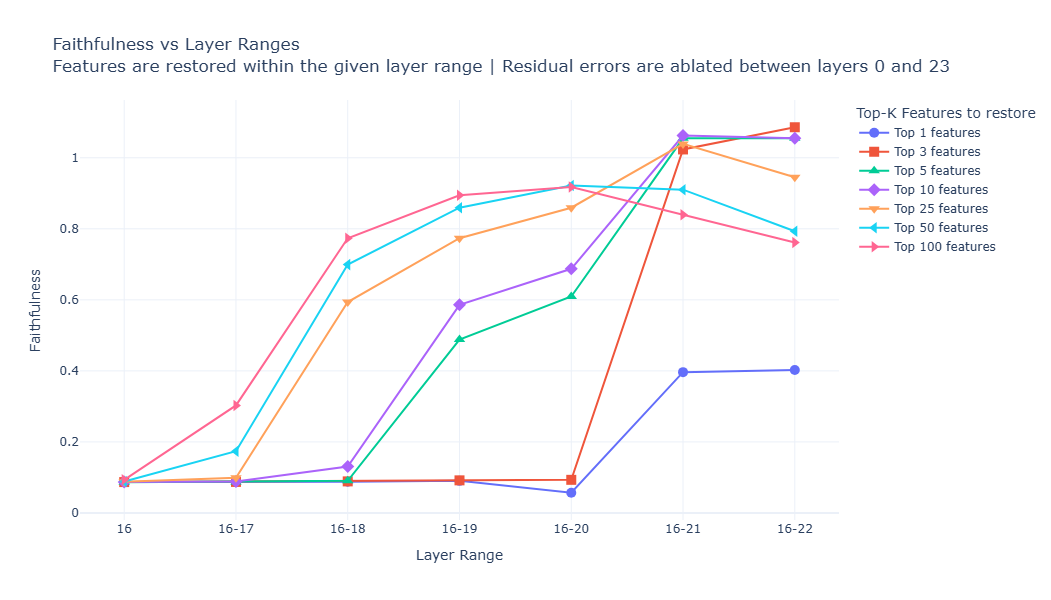

Layer Range Faithfulness Summary:

Layer Range 16-22:
  Top 1 features: 0.4023
  Top 3 features: 1.0859
  Top 5 features: 1.0547
  Top 10 features: 1.0547
  Top 25 features: 0.9453
  Top 50 features: 0.7930
  Top 100 features: 0.7617

Layer Range 16-21:
  Top 1 features: 0.3965
  Top 3 features: 1.0234
  Top 5 features: 1.0547
  Top 10 features: 1.0625
  Top 25 features: 1.0391
  Top 50 features: 0.9102
  Top 100 features: 0.8398

Layer Range 16-20:
  Top 1 features: 0.0569
  Top 3 features: 0.0933
  Top 5 features: 0.6094
  Top 10 features: 0.6875
  Top 25 features: 0.8594
  Top 50 features: 0.9219
  Top 100 features: 0.9180

Layer Range 16-19:
  Top 1 features: 0.0903
  Top 3 features: 0.0918
  Top 5 features: 0.4883
  Top 10 features: 0.5859
  Top 25 features: 0.7734
  Top 50 features: 0.8594
  Top 100 features: 0.8945

Layer Range 16-18:
  Top 1 features: 0.0879
  Top 3 features: 0.0889
  Top 5 features: 0.0903
  Top 10 features: 0.1309
  Top 25 features: 0.5938
  Top 50 features: 

In [62]:
results_df = pd.read_csv(saving_dir / "faithfulness_with_different_topk_GF_last_token.csv")

plot_faithfulness_vs_layer_ranges(results_df, layers_to_extract, plot_stds=False)

## Ablation heatmap experiment (variable Ablation Error threshold)

This is a follow-up experiment where we repeated a version of the previous experiment for different values of the ablation error threshold.

In [124]:
import pandas as pd
from collections import defaultdict

layers_to_extract = generate_jagged_layer_list(16, 25)
print(layers_to_extract)

# Different thresholds for error node ablation
error_layer_thresholds = list(range(16, 25 + 1))
top_k_value = 25  # Fixed value for top-k features

evaluation_params = {
    'cutoff_early_layers': False,
    'always_ablate_positions': positions_to_select,
    'return_all_metrics': True,
    # 'use_zero_ablation': True, # Uncomment if you want to run a zero ablation variant
    
    'batch_size': 1024,
    'total_batches': None,
    'verbose': True
}

# Initialize data collection structures
results = defaultdict(list)
detailed_results = {}  # For storing comprehensive data that doesn't fit in a dataframe

# Store aggregation settings for consistent display
abs_scores = extraction_params['abs_scores']

[[16, 17, 18, 19, 20, 21, 22, 23, 24, 25], [16, 17, 18, 19, 20, 21, 22, 23, 24], [16, 17, 18, 19, 20, 21, 22, 23], [16, 17, 18, 19, 20, 21, 22], [16, 17, 18, 19, 20, 21], [16, 17, 18, 19, 20], [16, 17, 18, 19], [16, 17, 18], [16, 17], [16]]


In [125]:
# Reset the hooks to avoid weird bugs
sfc_model.model.reset_hooks()
if RUN_WITH_SAES:
    sfc_model._reset_sae_hooks()
clear_cache()

circuit_evaluator = CircuitEvaluator(sfc_model)

In [ ]:
for layer_idx, layer in enumerate(layers_to_extract):
    print(f"\n{'='*80}\nLAYER {layer}\n{'='*80}")
    
    # First, extract the features once (since we're using a fixed top_k)
    selected_nodes_info = circuit_evaluator.sfc_node_scores.get_top_k_features_by_layer(
        layer, 
        top_k_counts=top_k_value,
        verbose=False,  # Turn off built-in verbose output for cleaner display
        **extraction_params
    )
    
    # Unpack the returned data
    feature_indices_dict, maximizing_positions_dict = selected_nodes_info
    
    # Loop over different error layer thresholds
    for threshold in error_layer_thresholds:
        print(f"\n{'-'*60}\nError Layer Threshold {threshold}\n{'-'*60}")
        
        # Create a unique key for this configuration
        config_key = f"layer_{layer}_top_{top_k_value}_error_threshold_{threshold}"
        
        # Define error ablation function for this threshold
        def ablate_error_hook(act_name):
            if 'hook_resid_post.hook_sae_error' not in act_name:
                return False
                
            # Split the input string by periods
            parts = act_name.split('.')
            error_layer_num = int(parts[1])
            
            return error_layer_num <= threshold
        
        # Update evaluation parameters with the current threshold function
        current_eval_params = evaluation_params.copy()
        current_eval_params['nodes_to_always_ablate'] = ablate_error_hook
        
        # Save the detailed feature information
        detailed_results[config_key] = {
            'feature_indices': feature_indices_dict,
            'maximizing_positions': maximizing_positions_dict,
            'layer': layer,
            'top_k': top_k_value,
            'error_threshold': threshold
        }
        
        # Prepare nodes_to_restore and feature_indices_to_restore for circuit evaluation
        nodes_to_restore = list(feature_indices_dict.keys())  # All nodes with selected features
        
        # Evaluate circuit faithfulness
        faithfulness_metrics, n_nodes_in_circuit = circuit_evaluator.evaluate_circuit_faithfulness(
            clean_dataset=clean_dataset,
            patched_dataset=corrupted_dataset,
            nodes_to_restore=nodes_to_restore,
            feature_indices_to_restore=feature_indices_dict,
            **current_eval_params
        )
        
        # Extract useful statistics from faithfulness_metrics
        mean_faithfulness = faithfulness_metrics.mean().item()
        std_faithfulness = faithfulness_metrics.std().item()
        
        # Store all the results
        results['layer'].append(layer)
        results['top_k'].append(top_k_value)
        results['error_threshold'].append(threshold)
        results['num_selected_features'].append(sum(len(indices) for indices in feature_indices_dict.values()))
        results['circuit_size'].append(n_nodes_in_circuit)
        results['mean_faithfulness'].append(mean_faithfulness)
        results['std_faithfulness'].append(std_faithfulness)
        
        # Also collect position statistics
        position_stats = {}
        for node_name, positions in maximizing_positions_dict.items():
            # Convert to numpy array for easier analysis
            pos_array = positions.cpu().numpy()
            position_stats[node_name] = {
                'position_counts': {int(pos): int(count) for pos, count in 
                                   zip(*np.unique(pos_array, return_counts=True))}
            }
        
        detailed_results[config_key]['position_stats'] = position_stats
        
        print(f"Layer {layer}, Error Threshold {threshold}: Mean faithfulness = {mean_faithfulness:.4f}")


LAYER [16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

------------------------------------------------------------
Error Layer Threshold 16
------------------------------------------------------------
Using single dataset for evaluation.
Restoring 10 nodes.
Restoring 250 specific features across 10 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.attn.hook_z.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.0.attn.hook_z.hook_sae_error in 7 positions
Ablating blocks.0.hook_mlp_out.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.0.hook_mlp_out.hook_sae_error in 7 positions
Ablating blocks.0.hook_resid_post.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.0.hook_resid_post.hook_sae_error in 7 positions
Ablating blocks.1.attn.hook_z.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.1.attn.hook_z.hook_sae_error in 7 positions
Ablating blocks.1.hook_mlp_out.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.1.hook_mlp_out.hook_sae_error in 7 positions
Abl

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.

### Plotting

In [ ]:
# Create DataFrame from the collected results
results_df = pd.DataFrame(results)

SAVING_NAME_SUFFIX = 'GF_last_token'
SAVING_NAME_SUFFIX = '_' + SAVING_NAME_SUFFIX if SAVING_NAME_SUFFIX else SAVING_NAME_SUFFIX

SAVING_NAME_RESULTS = f'faithfulness_with_error_thresholds{SAVING_NAME_SUFFIX}.csv'
SAVING_NAME_DETAILED = f'faithfulness_with_error_thresholds_detailed{SAVING_NAME_SUFFIX}.pkl'

# Display the results
print("\nSummary of results:")
print(results_df)

# If needed, convert layer values to proper types
# This handles cases where layer might be a list or the last element of a range
results_df['layer'] = results_df['layer'].apply(lambda x: x if isinstance(x, int) else max(x))

# Save the results for future use
results_df.to_csv(saving_dir / SAVING_NAME_RESULTS, index=False)

# Save detailed results as pickle
import pickle
with open(saving_dir / SAVING_NAME_DETAILED, "wb") as f:
    pickle.dump(detailed_results, f)

print(f"\nResults saved to {SAVING_NAME_RESULTS} and {SAVING_NAME_DETAILED} within {saving_dir}")

In [ ]:
def plot_faithfulness_heatmap(results_df, layer_ranges=None):
    """
    Create a heatmap showing faithfulness across layer ranges and error thresholds
    
    Args:
        results_df: DataFrame containing results with layer, error_threshold and mean_faithfulness columns
        layer_ranges: Optional list of layer ranges used in the experiment
                      e.g., [[18, 19, 20, 21, 22], [18, 19, 20, 21], ...]
                      If provided, x-axis labels will show ranges instead of just the max layer
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Extract unique layers and thresholds
    layers = sorted(results_df['layer'].unique())
    thresholds = sorted(results_df['error_threshold'].unique())
    
    # Create a 2D array for the heatmap
    heatmap_data = np.zeros((len(thresholds), len(layers)))
    
    # Fill the heatmap data
    for i, threshold in enumerate(thresholds):
        for j, layer in enumerate(layers):
            # Find the matching row in results_df
            matching_rows = results_df[(results_df['layer'] == layer) & 
                                      (results_df['error_threshold'] == threshold)]
            
            if not matching_rows.empty:
                heatmap_data[i, j] = matching_rows['mean_faithfulness'].iloc[0]
    
    # Create x-axis labels
    if layer_ranges is not None:
        # Create a mapping from max layer to range label
        layer_to_label = {}
        for layer_range in layer_ranges:
            max_layer = max(layer_range)
            if len(layer_range) > 1:
                label = f"{min(layer_range)}-{max(layer_range)}"
            else:
                label = str(layer_range[0])
            layer_to_label[max_layer] = label
        
        # Apply mapping to get labels in the correct order
        x_labels = [layer_to_label.get(layer, str(layer)) for layer in layers]
    else:
        x_labels = [str(layer) for layer in layers]
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Create the heatmap
    ax = sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", 
                    xticklabels=x_labels, yticklabels=thresholds,
                    vmin=0, vmax=1.0, cbar_kws={'label': 'Faithfulness'})
    
    # Customize the plot
    plt.xlabel('Layer Range (Max Layer)', fontsize=12)
    plt.ylabel('Error Layer Threshold', fontsize=12)
    plt.title('Faithfulness Across Layer Ranges and Error Thresholds', fontsize=14)
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('faithfulness_heatmap.png', dpi=300)
    plt.show()
    
    # Print summary of best configurations
    print("Top 5 configurations by faithfulness:")
    flat_data = []
    for i, threshold in enumerate(thresholds):
        for j, layer in enumerate(layers):
            flat_data.append({
                'layer': layers[j],
                'error_threshold': thresholds[i],
                'faithfulness': heatmap_data[i, j],
                'label': f"Layer {x_labels[j]}, Error Threshold {thresholds[i]}"
            })
    
    # Sort by faithfulness and display top 5
    flat_data.sort(key=lambda x: x['faithfulness'], reverse=True)
    for i, config in enumerate(flat_data[:5]):
        print(f"{i+1}. {config['label']}: {config['faithfulness']:.4f}")
    
    return heatmap_data, x_labels, thresholds

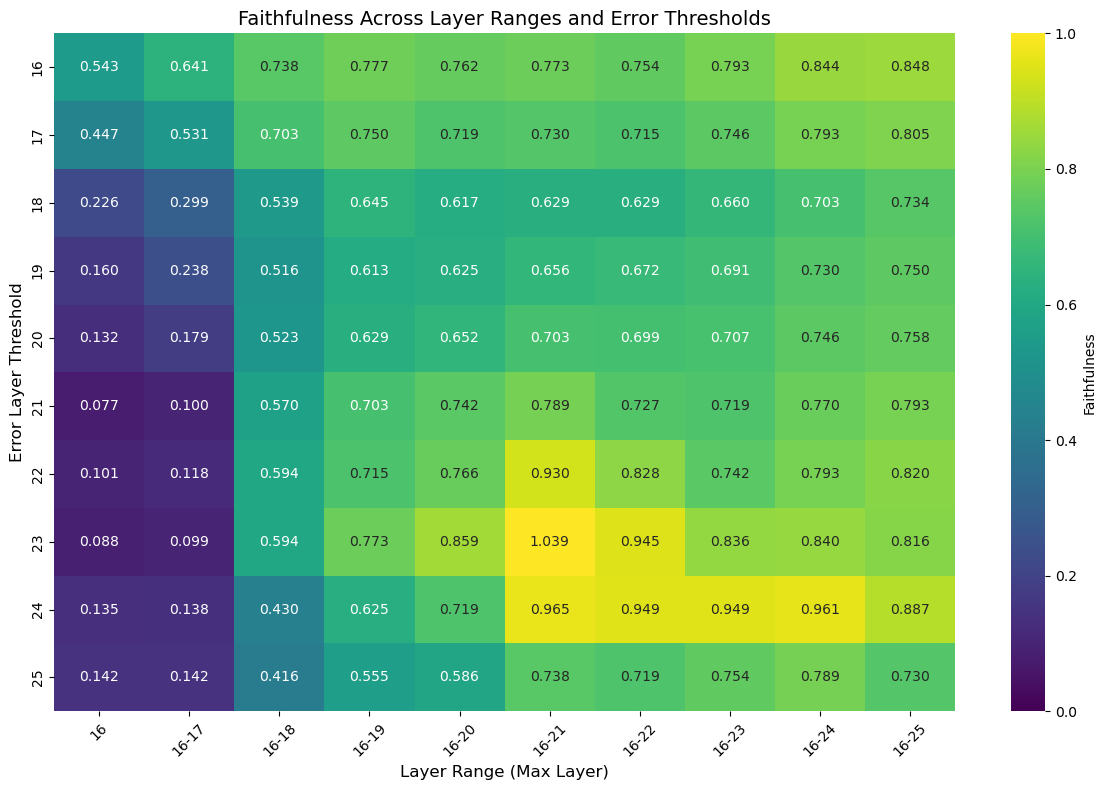

Top 5 configurations by faithfulness:
1. Layer 16-21, Error Threshold 23: 1.0391
2. Layer 16-21, Error Threshold 24: 0.9648
3. Layer 16-24, Error Threshold 24: 0.9609
4. Layer 16-22, Error Threshold 24: 0.9492
5. Layer 16-23, Error Threshold 24: 0.9492


In [130]:
# Plot the heatmap
heatmap_data, x_labels, thresholds = plot_faithfulness_heatmap(results_df, layers_to_extract)

## (Errors) Sliding window ablation

This is a section for reproducing our results from "Sliding window ablation" section

In [19]:
import pandas as pd
from collections import defaultdict

# Define ranges for error layers to test
# Use for defining ablation window config below
error_layers_to_ablate = list(range(26))  # From 0 to 25 # 26


evaluation_params_error = {
    # the params below should generally be fixed as they are
    'cutoff_early_layers': False,
    'always_ablate_positions': positions_to_select,
    'return_all_metrics': True,

    # these params are modifable 
    # 'use_zero_ablation': True, # Uncomment if you want to run a zero ablation variant
    'batch_size': 1024,
    'total_batches': None,
    'verbose': True
}

# Initialize data collection structures
results = defaultdict(list)

In [20]:
# Initialize data collection structures
error_ablation_results = defaultdict(list)

# Define window parameters
window_width = 4
window_step = 1
max_right_bound = error_layers_to_ablate[-1]

# Loop over sliding windows of error layers to ablate
window_left = error_layers_to_ablate[0]
window_right = window_left + window_width - 1

window_left, window_right, window_right - window_left + 1

(0, 3, 4)

In [23]:
# Reset the hooks to avoid weird bugs
sfc_model.model.reset_hooks()
if RUN_WITH_SAES:
    sfc_model._reset_sae_hooks()
clear_cache()

In [24]:
print("--- Running Sliding Window Ablation for Error Nodes ---")
while window_right <= max_right_bound:
    current_range = list(range(window_left, window_right + 1))
    print(f"Ablating Error Layers {current_range}...")
    
    # This function needs to be redefined in each loop iteration
    # to capture the current window_left and window_right values.
    def ablate_error_hook(act_name, left=window_left, right=window_right):
        if 'hook_resid_post.hook_sae_error' not in act_name:
            return False
        
        parts = act_name.split('.')
        error_layer_num = int(parts[1])
        return left <= error_layer_num <= right

    current_eval_params = evaluation_params_error.copy()
    current_eval_params['nodes_to_always_ablate'] = ablate_error_hook
    
    faithfulness_metrics, _ = circuit_evaluator.evaluate_circuit_faithfulness(
        clean_dataset=clean_dataset,
        patched_dataset=corrupted_dataset,
        **current_eval_params
    )
    
    # Calculate Sum of SFC Scores for Error Nodes in Window
    window_sfc_score_sum = 0.0
    for node_name, scores_tensor in circuit_evaluator.sfc_node_scores.node_scores.items():
        if 'hook_resid_post.hook_sae_error' in node_name:
            layer_num = int(node_name.split('.')[1])
            if window_left <= layer_num <= window_right:
                window_sfc_score_sum += scores_tensor[positions_to_select].sum().item()
    
    faithfulness_finite_mask = torch.isfinite(faithfulness_metrics)
    mean_faithfulness = faithfulness_metrics[faithfulness_finite_mask].mean().item()
    std_faithfulness = faithfulness_metrics[faithfulness_finite_mask].std().item()

    # f_series = pd.Series(faithfulness_metrics[faithfulness_finite_mask])
    # print(f_series.describe())
    
    error_ablation_results['window_left'].append(window_left)
    error_ablation_results['window_right'].append(window_right)
    error_ablation_results['mean_faithfulness'].append(mean_faithfulness)
    error_ablation_results['std_faithfulness'].append(std_faithfulness)
    error_ablation_results['sfc_score_sum'].append(window_sfc_score_sum)
    
    window_left += window_step
    window_right += window_step
    clear_cache()

# Convert the results to a DataFrame
error_ablation_results_df = pd.DataFrame(error_ablation_results)
print("\n--- Error Node Ablation Summary ---")
print(error_ablation_results_df)

--- Running Sliding Window Ablation for Error Nodes ---
Ablating Error Layers [0, 1, 2, 3]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Computing empty circuit metrics (will be cached)...
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.attn.hook_z.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.0.attn.hook_z.hook_sae_error in 7 positions
Ablating blocks.0.hook_mlp_out.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.0.hook_mlp_out.hook_sae_error in 7 positions
Ablating blocks.0.hook_resid_post.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.0.hook_resid_post.hook_sae_error in 7 positions
Ablating blocks.1.attn.hook_z.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.1.attn.hook_z.hook_sae_error in 7 positions
Ablating blocks.1.hook_mlp_out.hook_sae_acts_post in 114688 positions
    with [16384, 16384, 16384, 16384, 16384, 16384, 16384] features
Ablating blocks.1.hook_mlp_out.hook_sae_error in 7 positions
Abl

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.1.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [2, 3, 4, 5]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.2.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [3, 4, 5, 6]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.3.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [4, 5, 6, 7]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.4.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [5, 6, 7, 8]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.5.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [6, 7, 8, 9]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.6.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [7, 8, 9, 10]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.7.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [8, 9, 10, 11]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.8.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [9, 10, 11, 12]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.9.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [10, 11, 12, 13]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.10.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [11, 12, 13, 14]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.11.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [12, 13, 14, 15]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.12.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [13, 14, 15, 16]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.13.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [14, 15, 16, 17]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.14.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [15, 16, 17, 18]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.15.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [16, 17, 18, 19]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.16.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [17, 18, 19, 20]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.17.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [18, 19, 20, 21]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.18.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [19, 20, 21, 22]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.19.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [20, 21, 22, 23]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.20.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [21, 22, 23, 24]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.21.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.
Ablating Error Layers [22, 23, 24, 25]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.22.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 1 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 1 positions
Using cached empty circuit metrics.

--- Error Node Ablation Summary ---
    window_left  window_right  mean_faithfulness  std_faithfulness  \
0             0             3           0.996094          0.079102   
1             1             4           1.015625          0.076660   
2             2             5           0.996094          0.097168   
3             3             6           0.968750          0.103027   
4             4             7           0.933594          0.129883   
5             5             8           0.914062          0.142578   
6             6             9           0.886719          0.153320   
7             7            10           0.882812          0.180664   
8             8            11        

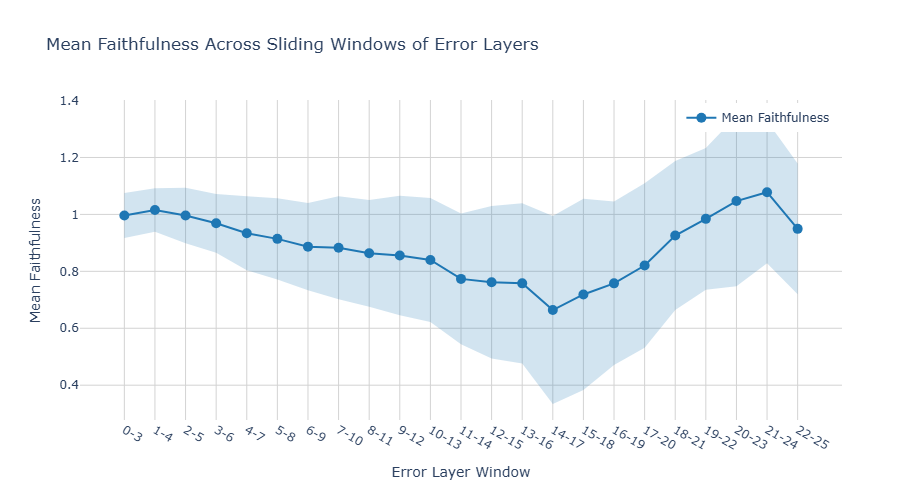


Summary of Results:
--------------------------------------------------------------------------------
Window         Mean Faithfulness   Std Faithfulness
--------------------------------------------------------------------------------
0-3            0.9961              0.0791
1-4            1.0156              0.0767
2-5            0.9961              0.0972
3-6            0.9688              0.1030
4-7            0.9336              0.1299
5-8            0.9141              0.1426
6-9            0.8867              0.1533
7-10           0.8828              0.1807
8-11           0.8633              0.1875
9-12           0.8555              0.2100
10-13          0.8398              0.2178
11-14          0.7734              0.2295
12-15          0.7617              0.2676
13-16          0.7578              0.2812
14-17          0.6641              0.3301
15-18          0.7188              0.3359
16-19          0.7578              0.2871
17-20          0.8203              0.2891
18-21    

In [111]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import plotly.io as pio

SAVING_NAME_SUFFIX = f'GF_{window_width}'
SAVING_NAME_SUFFIX = '_' + SAVING_NAME_SUFFIX if SAVING_NAME_SUFFIX else SAVING_NAME_SUFFIX

# Create a DataFrame for easier plotting with Plotly
df = pd.DataFrame({
    'Window Left': error_ablation_results_df['window_left'],
    'Window Right': error_ablation_results_df['window_right'],
    'Mean Faithfulness': error_ablation_results_df['mean_faithfulness'],
    'Std Faithfulness': error_ablation_results_df['std_faithfulness']
})

# Create window labels for the x-axis (e.g., "0-3", "1-4", etc.)
df['Window Label'] = df.apply(lambda row: f"{int(row['Window Left'])}-{int(row['Window Right'])}", axis=1)

# Calculate window midpoints for plotting
df['Window Midpoint'] = (df['Window Left'] + df['Window Right']) / 2

# Create the figure
fig = go.Figure()

# Add the line and markers
fig.add_trace(go.Scatter(
    x=df['Window Midpoint'],
    y=df['Mean Faithfulness'],
    mode='lines+markers',
    name='Mean Faithfulness',
    line=dict(color='#1f77b4', width=2),
    marker=dict(size=10, color='#1f77b4'),
))

# Add error bars
fig.add_trace(go.Scatter(
    x=np.concatenate([df['Window Midpoint'], df['Window Midpoint'][::-1]]),
    y=np.concatenate([
        df['Mean Faithfulness'] + df['Std Faithfulness'],
        (df['Mean Faithfulness'] - df['Std Faithfulness'])[::-1]
    ]),
    fill='toself',
    fillcolor='rgba(31, 119, 180, 0.2)',
    line=dict(color='rgba(255, 255, 255, 0)'),
    hoverinfo='skip',
    showlegend=False
))

# Customize the layout
fig.update_layout(
    title='Mean Faithfulness Across Sliding Windows of Error Layers',
    xaxis=dict(
        title='Error Layer Window',
        tickmode='array',
        tickvals=df['Window Midpoint'],
        ticktext=df['Window Label'],
        gridcolor='lightgray'
    ),
    yaxis=dict(
        title='Mean Faithfulness',
        gridcolor='lightgray',
        dtick=0.2,
    ),
    hovermode='x unified',
    template='plotly_white',
    width=900,
    height=500,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )
)

# Add custom hover text with more information
hover_text = [f"Window: {left}-{right}<br>Mean Faithfulness: {mean:.4f}<br>Std Deviation: {std:.4f}" 
              for left, right, mean, std in zip(
                  df['Window Left'], df['Window Right'], 
                  df['Mean Faithfulness'], df['Std Faithfulness']
              )]
fig.data[0].hovertext = hover_text
fig.data[0].hoverinfo = "text"

# Show the figure
fig.show()

pio.write_image(fig, f"sliding_window{SAVING_NAME_SUFFIX}.png", format='png', scale=4, width=1000, height=500)

# Print a summary table of the results
print("\nSummary of Results:")
print("-" * 80)
print(f"{'Window':<15}{'Mean Faithfulness':<20}{'Std Faithfulness'}")
print("-" * 80)
for i in range(len(df)):
    print(f"{df['Window Label'].iloc[i]:<15}{df['Mean Faithfulness'].iloc[i]:<20.4f}{df['Std Faithfulness'].iloc[i]:.4f}")

### Expanding window ablation

In [ ]:
# Reset the hooks to avoid weird bugs
sfc_model.model.reset_hooks()
if RUN_WITH_SAES:
    sfc_model._reset_sae_hooks()
clear_cache()

#### Fixed Right Bound

In [83]:
import pandas as pd
from collections import defaultdict

# --- Configuration ---
FIXED_WINDOW_RIGHT = 25

# --- Data Collection ---
expanding_window_results = defaultdict(list)

print(f"\n{'='*80}\nRUNNING EXPANDING WINDOW ABLATION (ABLATING [L, {FIXED_WINDOW_RIGHT}])\n{'='*80}")

# --- New Loop Structure ---
# The left boundary 'L' will move from 0 up to the fixed right boundary.
for window_left in range(0, FIXED_WINDOW_RIGHT + 1):
    window_right = FIXED_WINDOW_RIGHT  # Right boundary is always fixed
    current_range = list(range(window_left, window_right + 1))
    print(f"Ablating Error Layers in range: {current_range}...")
    
    # Redefine the hook in each loop iteration to capture the current window values
    def ablate_error_hook(act_name, left=window_left, right=window_right):
        if 'hook_resid_post.hook_sae_error' not in act_name: return False
        parts = act_name.split('.'); error_layer_num = int(parts[1])
        return left <= error_layer_num <= right

    current_eval_params = evaluation_params_error.copy()
    current_eval_params['nodes_to_always_ablate'] = ablate_error_hook
    
    # Evaluate faithfulness
    faithfulness_metrics, _ = circuit_evaluator.evaluate_circuit_faithfulness(
        clean_dataset=clean_dataset, patched_dataset=None, **current_eval_params
    )
    
    # Calculate Sum of SFC Scores for the ablated nodes
    window_sfc_score_sum = 0.0
    for node_name, scores_tensor in circuit_evaluator.sfc_node_scores.node_scores.items():
        if 'hook_resid_post.hook_sae_error' in node_name:
            layer_num = int(node_name.split('.')[1])
            if window_left <= layer_num <= window_right:
                window_sfc_score_sum += scores_tensor[positions_to_select].sum().item()
    
    # Process and store results
    faithfulness_finite_mask = torch.isfinite(faithfulness_metrics)
    mean_faithfulness = faithfulness_metrics[faithfulness_finite_mask].mean().item()
    std_faithfulness = faithfulness_metrics[faithfulness_finite_mask].std().item()
    
    expanding_window_results['window_left'].append(window_left)
    expanding_window_results['window_right'].append(window_right)
    expanding_window_results['mean_faithfulness'].append(mean_faithfulness)
    expanding_window_results['std_faithfulness'].append(std_faithfulness)
    expanding_window_results['sfc_score_sum'].append(window_sfc_score_sum)
    
    clear_cache()

# --- Display and Save Results ---
expanding_window_error_results_df = pd.DataFrame(expanding_window_results)
print("\n--- Expanding Window Error Ablation Summary ---")
print(expanding_window_error_results_df)

# Save the DataFrame
save_path = saving_dir / f"faithfulness_expanding_window_to_{FIXED_WINDOW_RIGHT}_GF.csv"
expanding_window_error_results_df.to_csv(save_path, index=False)
print(f"Results saved to {save_path}")


RUNNING EXPANDING WINDOW ABLATION (ABLATING [L, 25])
Ablating Error Layers in range: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.1.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.1.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.2.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.2.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.3.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_pos

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.3.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.4.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_po

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.4.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.5.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_p

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.5.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.6.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.6.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.7.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.7.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.8.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resi

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.8.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.9.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_res

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.9.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.10.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_re

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.10.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.11.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_r

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.11.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.12.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circui

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.12.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.13.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circuit metrics.
Ablating Error Layers in range: [13, 14, 15, 16, 17, 1

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.13.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circuit metrics.
Ablating Error Layers in range: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]...
Using single dataset for evaluation

  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.14.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circuit metrics.
Ablating Error Layers in range: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.15.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circuit metrics.
Ablating Error Layers in range: [16, 17, 18, 19, 20, 21, 22, 23, 24, 25]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.16.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circuit metrics.
Ablating Error Layers in range: [17, 18, 19, 20, 21, 22, 23, 24, 25]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.17.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circuit metrics.
Ablating Error Layers in range: [18, 19, 20, 21, 22, 23, 24, 25]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.18.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circuit metrics.
Ablating Error Layers in range: [19, 20, 21, 22, 23, 24, 25]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.19.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circuit metrics.
Ablating Error Layers in range: [20, 21, 22, 23, 24, 25]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.20.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circuit metrics.
Ablating Error Layers in range: [21, 22, 23, 24, 25]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.21.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circuit metrics.
Ablating Error Layers in range: [22, 23, 24, 25]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.22.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circuit metrics.
Ablating Error Layers in range: [23, 24, 25]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.23.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circuit metrics.
Ablating Error Layers in range: [24, 25]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.24.hook_resid_post.hook_sae_error in 2 positions
Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circuit metrics.
Ablating Error Layers in range: [25]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.25.hook_resid_post.hook_sae_error in 2 positions
Using cached empty circuit metrics.

--- Expanding Window Error Ablation Summary ---
    window_left  window_right  mean_faithfulness  std_faithfulness  \
0             0            25           0.131836          0.730469   
1             1            25           0.116211          0.777344   
2             2            25           0.142578          0.785156   
3             3            25           0.146484          0.824219   
4             4            25           0.132812          0.785156   
5             5            25           0.133789          0.789062   
6             6            25           0.127930          0.804688   
7             7            25           0.137695          0.796875   
8             8            25           0.124023          0.839844   
9             9            25           0.160156          0.890625   
10           10            25           0.163086          0.925781   
11        

In [38]:
# ablate_errors_but_restore_features_GF_dataset.py

# --- Plotting Function for the Expanding Window Experiment ---

from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_expanding_window_results(results_df):
    """
    Plots the results of the expanding window error ablation experiment.
    
    Args:
        results_df: DataFrame from the experiment, with 'window_left', 
                    'mean_faithfulness', and 'sfc_score_sum' columns.
    """
    if results_df.empty:
        print("No results to plot.")
        return
        
    # Create figure with a secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add Faithfulness trace
    fig.add_trace(go.Scatter(
        x=results_df['window_left'],
        y=results_df['mean_faithfulness'],
        mode='lines+markers',
        name='Mean Faithfulness',
        line=dict(color='royalblue', width=2.5),
        marker=dict(size=8),
        hovertext=[f"Ablating [{l},{r}]<br>Faithfulness: {m:.3f} ± {s:.3f}" for l,r,m,s in zip(results_df.window_left, results_df.window_right, results_df.mean_faithfulness, results_df.std_faithfulness)],
        hoverinfo='text'
    ), secondary_y=False)

    # Add SFC Score Sum trace
    fig.add_trace(go.Scatter(
        x=results_df['window_left'],
        y=results_df['sfc_score_sum'],
        mode='lines+markers',
        name='Sum of Ablated SFC Scores',
        line=dict(color='firebrick', dash='dot', width=2),
        marker=dict(symbol='x-thin', size=8),
        hovertext=[f"Ablating [{l},{r}]<br>SFC Sum: {s:.2f}" for l,r,s in zip(results_df.window_left, results_df.window_right, results_df.sfc_score_sum)],
        hoverinfo='text'
    ), secondary_y=True)

    # Finalize Layout
    fixed_right_boundary = results_df['window_right'].iloc[0]
    fig.update_layout(
        title=f'<b>Faithfulness when Ablating Error Layers in Range [L, {fixed_right_boundary}]</b>',
        xaxis_title='Left Boundary of Ablation Window (L)',
        hovermode='x unified',
        template='plotly_white'
    )

    fig.update_xaxes(
        dtick=1,
        # Use 'window_left' for the range, matching the data being plotted
        range=[results_df['window_left'].min() - 0.5, results_df['window_left'].max() + 0.5] 
    )
    
    
    fig.update_yaxes(title_text="<b>Mean Faithfulness</b>", secondary_y=False, range=[-0.1, 1.05])
    fig.update_yaxes(title_text="<b>Sum of Ablated SFC Scores</b>", secondary_y=True)
    pio.write_image(fig, "expanding_left_window_gf.png", format='png', scale=4, width=1000, height=450)

    fig.show()

# --- Call the new plotting function ---
# Assumes `expanding_window_error_results_df` is available from the experiment cell.
plot_expanding_window_results(expanding_window_error_results_df)

NameError: name 'expanding_window_error_results_df' is not defined

In [85]:
# Reset the hooks to avoid weird bugs
sfc_model.model.reset_hooks()
if RUN_WITH_SAES:
    sfc_model._reset_sae_hooks()
clear_cache()

#### Fixed Left Bound

In [112]:
import pandas as pd
from collections import defaultdict

# --- Configuration ---
FIXED_WINDOW_LEFT = 0
MAX_RIGHT_BOUNDARY = sfc_model.model.cfg.n_layers - 1

# --- Data Collection ---
fixed_left_results = defaultdict(list)

print(f"\n{'='*80}\nRUNNING EXPANDING WINDOW ABLATION (ABLATING [{FIXED_WINDOW_LEFT}, R])\n{'='*80}")

# --- New Loop Structure ---
# The right boundary 'R' will move from the fixed left boundary up to the max layer.
for window_right in range(FIXED_WINDOW_LEFT, MAX_RIGHT_BOUNDARY + 1):
    window_left = FIXED_WINDOW_LEFT # Left boundary is always fixed
    current_range = list(range(window_left, window_right + 1))
    print(f"Ablating Error Layers in range: {current_range}...")
    
    def ablate_error_hook(act_name, left=window_left, right=window_right):
        if 'hook_resid_post.hook_sae_error' not in act_name: return False
        parts = act_name.split('.'); error_layer_num = int(parts[1])
        return left <= error_layer_num <= right

    current_eval_params = evaluation_params_error.copy()
    current_eval_params['nodes_to_always_ablate'] = ablate_error_hook
    
    faithfulness_metrics, _ = circuit_evaluator.evaluate_circuit_faithfulness(
        clean_dataset=clean_dataset, patched_dataset=None, **current_eval_params
    )
    
    window_sfc_score_sum = 0.0
    for node_name, scores_tensor in circuit_evaluator.sfc_node_scores.node_scores.items():
        if 'hook_resid_post.hook_sae_error' in node_name:
            layer_num = int(node_name.split('.')[1])
            if window_left <= layer_num <= window_right:
                window_sfc_score_sum += scores_tensor[positions_to_select].sum().item()
    
    faithfulness_finite_mask = torch.isfinite(faithfulness_metrics)
    mean_faithfulness = faithfulness_metrics[faithfulness_finite_mask].mean().item()
    std_faithfulness = faithfulness_metrics[faithfulness_finite_mask].std().item()
    
    fixed_left_results['window_left'].append(window_left)
    fixed_left_results['window_right'].append(window_right)
    fixed_left_results['mean_faithfulness'].append(mean_faithfulness)
    fixed_left_results['std_faithfulness'].append(std_faithfulness)
    fixed_left_results['sfc_score_sum'].append(window_sfc_score_sum)
    
    clear_cache()

# --- Display and Save Results ---
fixed_left_error_results_df = pd.DataFrame(fixed_left_results)
print("\n--- Fixed-Left Expanding Window Error Ablation Summary ---")
print(fixed_left_error_results_df)

save_path = saving_dir / f"faithfulness_fixed_left_expanding_window_errors.csv"
fixed_left_error_results_df.to_csv(save_path, index=False)
print(f"Results saved to {save_path}")


RUNNING EXPANDING WINDOW ABLATION (ABLATING [0, R])
Ablating Error Layers in range: [0]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:3 and cuda:2! (when checking argument for argument index in method wrapper_CUDA_gather)

In [39]:
# ablate_errors_but_restore_features_GF_dataset.py

# --- Plotting Function for the Fixed-Left Expanding Window Experiment ---

from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_fixed_left_expanding_window_results(results_df):
    """
    Plots the results of the fixed-left expanding window error ablation experiment.
    
    Args:
        results_df: DataFrame from the experiment, with 'window_right', 
                    'mean_faithfulness', and 'sfc_score_sum' columns.
    """
    if results_df.empty:
        print("No results to plot.")
        return
        
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add Faithfulness trace
    fig.add_trace(go.Scatter(
        x=results_df['window_right'],
        y=results_df['mean_faithfulness'],
        mode='lines+markers', name='Mean Faithfulness',
        line=dict(color='royalblue', width=2.5), marker=dict(size=8),
        hovertext=[f"Ablating [{l},{r}]<br>Faithfulness: {m:.3f} ± {s:.3f}" for l,r,m,s in zip(results_df.window_left, results_df.window_right, results_df.mean_faithfulness, results_df.std_faithfulness)],
        hoverinfo='text'
    ), secondary_y=False)

    # Add SFC Score Sum trace
    fig.add_trace(go.Scatter(
        x=results_df['window_right'],
        y=results_df['sfc_score_sum'],
        mode='lines+markers', name='Sum of Ablated SFC Scores',
        line=dict(color='firebrick', dash='dot', width=2), marker=dict(symbol='x-thin', size=8),
        hovertext=[f"Ablating [{l},{r}]<br>SFC Sum: {s:.2f}" for l,r,s in zip(results_df.window_left, results_df.window_right, results_df.sfc_score_sum)],
        hoverinfo='text'
    ), secondary_y=True)

    # Finalize Layout
    fixed_left_boundary = results_df['window_left'].iloc[0]
    fig.update_layout(
        title=f'<b>Faithfulness when Ablating Error Layers in Range [{fixed_left_boundary}, R]</b>',
        xaxis_title='Right Boundary of Ablation Window (R)',
        hovermode='x unified',
        template='plotly_white'
    )
    
    fig.update_yaxes(title_text="<b>Mean Faithfulness</b>", secondary_y=False, range=[-0.1, 1.1])
    fig.update_yaxes(title_text="<b>Sum of Ablated SFC Scores</b>", secondary_y=True)

    fig.update_xaxes(
        title_text='Right Boundary of Ablation Window (R)',
        dtick=1,  # Force a tick mark for every integer.
        range=[results_df['window_right'].min() - 0.5, results_df['window_right'].max() + 0.5] # Clip axis to data range.
    )

    pio.write_image(fig, "expanding_right_window_gf.png", format='png', scale=4, width=1000, height=450)

    fig.show()

# --- Call the new plotting function ---
# Assumes `fixed_left_error_results_df` is available from the experiment cell.
plot_fixed_left_expanding_window_results(fixed_left_error_results_df) # 

NameError: name 'fixed_left_error_results_df' is not defined

## (Features) Sliding window ablation

In [ ]:
# Reset the hooks to avoid weird bugs
sfc_model.model.reset_hooks()
if RUN_WITH_SAES:
    sfc_model._reset_sae_hooks()
clear_cache()

#### Top-K features ablation

We didn't use this method in the post, but this section allows to ablate an arbitrary number of SAE features within the ablation window.

In [115]:
import pandas as pd
from collections import defaultdict
import plotly.graph_objects as go
import numpy as np

# Define window parameters
window_width = 4
WINDOW_STEP = 1
MAX_LAYER = error_layers_to_ablate[-1]

# Define the number of top features to ablate in each window.
TOP_K_TO_ABLATE = [10] # 1, 5

# Parameters for selecting which resid_post features to ablate
FEATURE_EXTRACTION_PARAMS = {
    'abs_scores': False,
    'aggregation_type': 'max',
    'positions_to_select': positions_to_select, # Select features based on scores across all positions
    'include_components': ['hook_resid_post']
}

# Parameters for the faithfulness evaluation call
EVALUATION_PARAMS_FEATURES = {
    # the params below should generally be fixed as they are
    'cutoff_early_layers': False,
    'always_ablate_positions': positions_to_select,
    'return_all_metrics': True,

    # these params are modifable 
    # 'use_zero_ablation': True, # Uncomment if you want to run a zero ablation variant
    'batch_size': 1024,
    'total_batches': None,
    'verbose': True
}

EVALUATION_PARAMS_FEATURES

{'cutoff_early_layers': False,
 'always_ablate_positions': [6],
 'return_all_metrics': True,
 'batch_size': 1024,
 'total_batches': None,
 'verbose': True}

In [116]:
# --- Main Sliding Window Feature Ablation Loop ---

# This dictionary will store a results DataFrame for each top_k value
if 'feature_ablation_results_dict' not in locals():
    feature_ablation_results_dict = {}

for top_k in TOP_K_TO_ABLATE:
    print(f"\n{'='*80}\nRUNNING FOR TOP_K = {top_k}\n{'='*80}")

    # Reset hooks before starting a new run for a different K
    sfc_model.model.reset_hooks()
    if RUN_WITH_SAES:
        sfc_model._reset_sae_hooks()
    clear_cache()
    
    # Initialize results for this specific K
    results = defaultdict(list)
    
    # Loop over sliding windows of layers
    window_left = error_layers_to_ablate[0]
    window_right = window_left + WINDOW_WIDTH - 1

    while window_right <= MAX_LAYER:
        current_layer_range = list(range(window_left, window_right + 1))
        print(f"\n---> Ablating Top {top_k} resid_post features from layers {current_layer_range}...")
        
        # 1. Select the top-K features from the current window's layers
        selected_nodes_info = circuit_evaluator.sfc_node_scores.get_top_k_features_by_layer(
            current_layer_range, 
            top_k_counts=top_k,
            verbose=False,
            **FEATURE_EXTRACTION_PARAMS
        )
        
        feature_indices_to_ablate, _ = selected_nodes_info
        num_ablated_features = sum(len(indices) for indices in feature_indices_to_ablate.values())
        print(f"      Selected {num_ablated_features} features to ablate.")
        
        # 2. Evaluate faithfulness by ablating these specific features
        faithfulness_metrics, _ = circuit_evaluator.evaluate_circuit_faithfulness(
            clean_dataset=clean_dataset,
            patched_dataset=corrupted_dataset,
            feature_indices_to_ablate=feature_indices_to_ablate,
            **EVALUATION_PARAMS_FEATURES
        )

        # Calculate Sum of SFC Scores for Selected Features
        total_sfc_score_sum = 0.0
        for node_name, indices in feature_indices_to_ablate.items():
            scores_tensor = circuit_evaluator.sfc_node_scores.node_scores[node_name]
            if len(indices) > 0:
                 # First, select the rows (positions). Then, from those, select the columns (features).
                 selected_scores = scores_tensor[positions_to_select, :][:, indices]
                 total_sfc_score_sum += selected_scores.sum().item()
        
        # 3. Process and store the results for this window
        faithfulness_finite_mask = torch.isfinite(faithfulness_metrics)
        mean_faithfulness = faithfulness_metrics[faithfulness_finite_mask].mean().item()
        std_faithfulness = faithfulness_metrics[faithfulness_finite_mask].std().item()
        
        results['window_left'].append(window_left)
        results['window_right'].append(window_right)
        results['mean_faithfulness'].append(mean_faithfulness)
        results['std_faithfulness'].append(std_faithfulness)
        results['sfc_score_sum'].append(total_sfc_score_sum) # Store the sum
        
        print(f"      Window {current_layer_range}: Mean faithfulness = {mean_faithfulness:.4f} ± {std_faithfulness:.4f}")
        
        # Slide the window for the next iteration
        window_left += WINDOW_STEP
        window_right += WINDOW_STEP
        
        del faithfulness_metrics, feature_indices_to_ablate
        clear_cache()
        
    # Store the completed DataFrame for this K value
    feature_ablation_results_dict[top_k] = pd.DataFrame(results)

# --- Save all results to CSV ---
for top_k, df in feature_ablation_results_dict.items():
    print(f"\n--- Sliding Window Feature Ablation Summary (Top {top_k}) ---")
    print(df)
    save_path = saving_dir / f"faithfulness_sliding_window_resid_features_top{top_k}.csv"
    df.to_csv(save_path, index=False)
    print(f"Results saved to {save_path}")


RUNNING FOR TOP_K = 10

---> Ablating Top 10 resid_post features from layers [0, 1, 2, 3]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.1.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.2.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.3.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [0, 1, 2, 3]: Mean faithfulness = 1.0000 ± 0.0630

---> Ablating Top 10 resid_post features from layers [1, 2, 3, 4]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.1.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.2.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.3.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.4.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [1, 2, 3, 4]: Mean faithfulness = 0.9961 ± 0.0588

---> Ablating Top 10 resid_post features from layers [2, 3, 4, 5]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.2.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.3.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.4.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.5.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [2, 3, 4, 5]: Mean faithfulness = 0.9922 ± 0.0613

---> Ablating Top 10 resid_post features from layers [3, 4, 5, 6]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.3.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.4.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.5.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.6.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [3, 4, 5, 6]: Mean faithfulness = 0.9531 ± 0.0786

---> Ablating Top 10 resid_post features from layers [4, 5, 6, 7]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.4.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.5.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.6.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.7.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [4, 5, 6, 7]: Mean faithfulness = 0.8984 ± 0.0928

---> Ablating Top 10 resid_post features from layers [5, 6, 7, 8]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.5.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.6.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.7.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.8.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [5, 6, 7, 8]: Mean faithfulness = 0.8984 ± 0.0952

---> Ablating Top 10 resid_post features from layers [6, 7, 8, 9]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.6.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.7.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.8.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.9.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [6, 7, 8, 9]: Mean faithfulness = 0.9102 ± 0.0903

---> Ablating Top 10 resid_post features from layers [7, 8, 9, 10]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.7.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.8.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.9.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.10.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [7, 8, 9, 10]: Mean faithfulness = 0.8828 ± 0.1055

---> Ablating Top 10 resid_post features from layers [8, 9, 10, 11]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.8.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.9.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.10.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.11.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [8, 9, 10, 11]: Mean faithfulness = 0.8906 ± 0.0928

---> Ablating Top 10 resid_post features from layers [9, 10, 11, 12]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.9.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.10.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.11.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.12.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [9, 10, 11, 12]: Mean faithfulness = 0.9023 ± 0.0815

---> Ablating Top 10 resid_post features from layers [10, 11, 12, 13]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.10.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.11.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.12.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.13.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [10, 11, 12, 13]: Mean faithfulness = 0.8789 ± 0.0933

---> Ablating Top 10 resid_post features from layers [11, 12, 13, 14]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.11.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.12.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.13.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.14.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [11, 12, 13, 14]: Mean faithfulness = 0.8867 ± 0.0972

---> Ablating Top 10 resid_post features from layers [12, 13, 14, 15]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.12.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.13.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.14.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.15.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [12, 13, 14, 15]: Mean faithfulness = 0.8438 ± 0.1094

---> Ablating Top 10 resid_post features from layers [13, 14, 15, 16]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.13.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.14.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.15.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.16.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [13, 14, 15, 16]: Mean faithfulness = 0.7266 ± 0.1260

---> Ablating Top 10 resid_post features from layers [14, 15, 16, 17]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.14.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.15.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.16.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.17.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [14, 15, 16, 17]: Mean faithfulness = 0.6875 ± 0.1445

---> Ablating Top 10 resid_post features from layers [15, 16, 17, 18]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.15.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.16.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.17.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.18.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [15, 16, 17, 18]: Mean faithfulness = 0.5000 ± 0.1963

---> Ablating Top 10 resid_post features from layers [16, 17, 18, 19]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.16.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.17.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.18.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.19.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [16, 17, 18, 19]: Mean faithfulness = 0.0708 ± 0.2002

---> Ablating Top 10 resid_post features from layers [17, 18, 19, 20]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.17.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.18.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.19.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.20.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [17, 18, 19, 20]: Mean faithfulness = 0.1436 ± 0.1982

---> Ablating Top 10 resid_post features from layers [18, 19, 20, 21]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.18.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.19.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.20.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.21.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [18, 19, 20, 21]: Mean faithfulness = 0.0972 ± 0.0957

---> Ablating Top 10 resid_post features from layers [19, 20, 21, 22]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.19.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.20.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.21.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.22.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [19, 20, 21, 22]: Mean faithfulness = 0.0806 ± 0.1030

---> Ablating Top 10 resid_post features from layers [20, 21, 22, 23]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.20.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.21.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.22.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.23.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [20, 21, 22, 23]: Mean faithfulness = 0.0190 ± 0.0991

---> Ablating Top 10 resid_post features from layers [21, 22, 23, 24]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.21.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.22.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.23.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.24.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [21, 22, 23, 24]: Mean faithfulness = 0.0118 ± 0.1011

---> Ablating Top 10 resid_post features from layers [22, 23, 24, 25]...
      Selected 40 features to ablate.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.22.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.23.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.24.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.25.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
      Window [22, 23, 24, 25]: Mean faithfulness = 0.0076 ± 0.2246

--- Sliding Window Feature Ablation Summary (Top 5) ---
    window_left  window_right  mean_faithfulness  std_faithfulness  \
0             0             3           1.007812          0.061523   
1             1             4           1.007812          0.056885   
2             2             5           1.000000          0.060059   
3             3             6           0.968750          0.067871   
4             4             7           0.9296

In [98]:
# ablate_errors_but_restore_features_GF_dataset.py

# --- Plotting function for the Fixed Top-K Sliding Window Experiment ---

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd

def plot_fixed_k_sliding_window(feature_results_dict):
    """
    Plots the results of the fixed top-k sliding window feature ablation.
    Shows faithfulness on the left Y-axis and the sum of SFC scores on the right Y-axis.
    
    Args:
        feature_results_dict: A dictionary where keys are top_k values and values are 
                              the corresponding result DataFrames.
    """
    if not feature_results_dict:
        print("No results to plot.")
        return
        
    # Create a figure with a secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    colors = px.colors.qualitative.Plotly
    
    last_df = None # To set the x-axis ticks later
    for i, (top_k, df) in enumerate(feature_results_dict.items()):
        if df.empty:
            continue
        last_df = df
            
        color = colors[i % len(colors)]
        
        df['Window Label'] = df.apply(lambda row: f"{int(row['window_left'])}-{int(row['window_right'])}", axis=1)
        df['Window Midpoint'] = (df['window_left'] + df['window_right']) / 2
        
        # --- Faithfulness Trace (Left Y-Axis) ---
        fig.add_trace(go.Scatter(
            x=df['Window Midpoint'],
            y=df['mean_faithfulness'],
            mode='lines+markers',
            name=f'Ablate Top {top_k} Features',
            legendgroup=f'group_{top_k}',
            line=dict(color=color, width=2.5),
            marker=dict(size=8),
            hovertext=[f"Faithfulness: {m:.3f} ± {s:.3f}" for m,s in zip(df.mean_faithfulness, df.std_faithfulness)],
            hoverinfo='text+name'
        ), secondary_y=False)
        
        # --- SFC Score Sum Trace (Right Y-Axis) ---
        fig.add_trace(go.Scatter(
            x=df['Window Midpoint'],
            y=df['sfc_score_sum'],
            mode='lines',
            name=f'SFC Score Sum (Top {top_k})',
            legendgroup=f'group_{top_k}',
            line=dict(color=color, dash='dot', width=2),
            hovertext=[f"SFC Score Sum: {s:.2f}" for s in df.sfc_score_sum],
            hoverinfo='text+name',
            showlegend=False # Hide this from the legend to reduce clutter
        ), secondary_y=True)

    # --- Finalize Layout ---
    title_text = 'Faithfulness & Ablated Score Sum for Fixed Top-K Feature Ablation'
    
    if last_df is not None:
        fig.update_layout(
            title=title_text,
            xaxis=dict(
                title='Feature Ablation Layer Window',
                tickmode='array',
                tickvals=last_df['Window Midpoint'],
                ticktext=last_df['Window Label'],
                gridcolor='lightgray',
                tickangle=45
            ),
            hovermode='x unified',
            template='plotly_white',
            legend_title_text='Ablation Setting'
        )
    else:
        fig.update_layout(title=title_text)
        
    # Set Y-axis titles
    fig.update_yaxes(title_text="<b>Mean Faithfulness</b>", secondary_y=False, range=[-0.1, 1.05])
    fig.update_yaxes(title_text="<b>Sum of Ablated SFC Scores</b>", secondary_y=True)
        
    fig.show()


# --- Call the rolled-back plotting function ---
if feature_ablation_results_dict:
    plot_fixed_k_sliding_window(feature_ablation_results_dict)

#### Feature baselines implementation

In [95]:
# Reset the hooks to avoid weird bugs
sfc_model.model.reset_hooks()
if RUN_WITH_SAES:
    sfc_model._reset_sae_hooks()
clear_cache()

This is the variant we used in the post, implementing different feature baselines or `SELECTION_MODES` as named below.

In [96]:
# --- NEW Experiment: Feature Ablation via Layer-by-Layer Score Matching ---

import pandas as pd
from collections import defaultdict

# --- Configuration ---
# Define the three selection strategies we want to test
SELECTION_MODES = ['committee_matching'] # committee_matching 'top_1', 'min_abs_diff'

WINDOW_WIDTH = 4
WINDOW_STEP = 1
MAX_LAYER = error_layers_to_ablate[-1]

# Parameters for the faithfulness evaluation call
EVALUATION_PARAMS_FEATURES = {
    # the params below should generally be fixed as they are
    'cutoff_early_layers': False,
    'always_ablate_positions': positions_to_select,
    'return_all_metrics': True,

    # these params are modifable 
    # 'use_zero_ablation': True, # Uncomment if you want to run a zero ablation variant
    'batch_size': 1024,
    'total_batches': None,
    'verbose': True
}

# This dictionary will store the final DataFrame for each selection mode
all_feature_ablation_results = {}

# --- Main Loop over Selection Modes ---
for mode in SELECTION_MODES:
    print(f"\n{'='*80}\nRUNNING FEATURE ABLATION | SELECTION MODE: {mode}\n{'='*80}")
    
    sfc_model.model.reset_hooks()
    if RUN_WITH_SAES:
        sfc_model._reset_sae_hooks()
    clear_cache()

    mode_results = defaultdict(list)
    window_left, window_right = error_layers_to_ablate[0], error_layers_to_ablate[0] + WINDOW_WIDTH - 1

    while window_right <= MAX_LAYER:
        current_layer_range = list(range(window_left, window_right + 1))
        print(f"Processing window {current_layer_range}...")

        feature_indices_to_ablate = defaultdict(list)
        committee_sizes_for_window = []

        # Find the best feature(s) for each layer in the current window
        for layer_num in current_layer_range:
            error_node_name = f"blocks.{layer_num}.hook_resid_post.hook_sae_error"
            feature_node_name = f"blocks.{layer_num}.hook_resid_post.hook_sae_acts_post"

            if feature_node_name not in circuit_evaluator.sfc_node_scores.node_scores:
                print(f"  Warning: No scores for {feature_node_name}. Skipping layer.")
                continue

            feature_scores_at_pos = circuit_evaluator.sfc_node_scores.node_scores[feature_node_name][positions_to_select, :].sum(dim=0)
            best_feature_indices_for_layer = []

            # --- Mode-Specific Feature Selection Logic ---
            if mode == 'top_1':
                # Select the single feature with the highest score.
                best_feature_idx = torch.argmax(feature_scores_at_pos).item()
                best_feature_indices_for_layer.append(best_feature_idx)

            elif mode == 'min_abs_diff':
                # Select the single feature whose score is closest to the error node's score.
                if error_node_name not in circuit_evaluator.sfc_node_scores.node_scores:
                    continue
                target_score = circuit_evaluator.sfc_node_scores.node_scores[error_node_name][positions_to_select].sum().item()
                diffs = torch.abs(feature_scores_at_pos - target_score)
                best_feature_idx = torch.argmin(diffs).item()
                best_feature_indices_for_layer.append(best_feature_idx)

            elif mode == 'committee_matching':
                # Select one or more features to meet or exceed the error node's score.
                if error_node_name not in circuit_evaluator.sfc_node_scores.node_scores:
                    continue
                target_score = circuit_evaluator.sfc_node_scores.node_scores[error_node_name][positions_to_select].sum().item()
                candidate_indices = torch.where(feature_scores_at_pos >= target_score)[0]

                if len(candidate_indices) > 0:
                    # If any single features are strong enough, pick the one that's "just right".
                    candidate_scores = feature_scores_at_pos[candidate_indices]
                    best_feature_idx = candidate_indices[torch.argmin(candidate_scores)].item()
                    best_feature_indices_for_layer.append(best_feature_idx)
                else:
                    # Fallback: If no single feature is strong enough, form a "committee".
                    print(f"  Info: No single feature >= {target_score:.3f} in layer {layer_num}. Forming committee.")
                    sorted_scores, sorted_indices = torch.sort(feature_scores_at_pos, descending=True)
                    cumulative_scores = torch.cumsum(sorted_scores, dim=0)
                    committee_size_tensor = torch.where(cumulative_scores >= target_score)[0]

                    if len(committee_size_tensor) > 0:
                        # Find the smallest committee whose sum exceeds the target.
                        committee_size = committee_size_tensor[0].item() + 1
                    else:
                        # If all features combined aren't enough, take all of them.
                        print(f"  Warning: All features in layer {layer_num} do not sum to target. Taking all.")
                        committee_size = len(sorted_indices)
                    
                    best_feature_indices_for_layer.extend(sorted_indices[:committee_size].tolist())
                # end elif block
            # Store the selected features for this layer.
            feature_indices_to_ablate[feature_node_name].extend(best_feature_indices_for_layer)
            if mode == 'committee_matching':
                committee_sizes_for_window.append(len(best_feature_indices_for_layer))
            
        # --- Evaluate Faithfulness and Store Results for the Window ---
        # Calculate the actual sum of AtP scores for the selected features.
        actual_sfc_score_sum = 0.0
        for node_name, indices in feature_indices_to_ablate.items():
            scores_tensor = circuit_evaluator.sfc_node_scores.node_scores[node_name]
            if len(indices) > 0:
                selected_scores = scores_tensor[positions_to_select, :][:, indices]
                actual_sfc_score_sum += selected_scores.sum().item()

        # Run the main evaluation.
        faithfulness_metrics, _ = circuit_evaluator.evaluate_circuit_faithfulness(
            clean_dataset=clean_dataset,
            patched_dataset=None,
            feature_indices_to_ablate=feature_indices_to_ablate,
            **EVALUATION_PARAMS_FEATURES
        )

        # Process and store the metrics.
        faithfulness_finite_mask = torch.isfinite(faithfulness_metrics)
        mean_faithfulness = faithfulness_metrics[faithfulness_finite_mask].mean().item()
        std_faithfulness = faithfulness_metrics[faithfulness_finite_mask].std().item()

        mode_results['window_left'].append(window_left)
        mode_results['window_right'].append(window_right)
        mode_results['mean_faithfulness'].append(mean_faithfulness)
        mode_results['std_faithfulness'].append(std_faithfulness)
        mode_results['sfc_score_sum'].append(actual_sfc_score_sum)
        
        if mode == 'committee_matching':
            mode_results['committee_sizes'].append(committee_sizes_for_window)

        # Advance the sliding window.
        window_left += WINDOW_STEP
        window_right += WINDOW_STEP
        clear_cache()
        # end while
    # Store the final DataFrame for this mode.
    all_feature_ablation_results[mode] = pd.DataFrame(mode_results)
    print(f"\n--- Feature Ablation Summary (Mode: {mode}) ---")
    print(all_feature_ablation_results[mode])


RUNNING FEATURE ABLATION | SELECTION MODE: committee_matching
Processing window [0, 1, 2, 3]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.0.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.1.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.2.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.3.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Using cached empty circuit metrics.
Processing window [1, 2, 3, 4]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.1.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.2.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.3.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.4.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Using cached empty circuit metrics.
Processing window [2, 3, 4, 5]...
  Info: No single feature >= 0.000 in layer 5. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.2.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.3.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.4.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.5.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
Processing window [3, 4, 5, 6]...
  Info: No single feature >= 0.000 in layer 5. Forming committee.
  Info: No single feature >= 0.001 in layer 6. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.3.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.4.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.5.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.6.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Using cached empty circuit metrics.
Processing window [4, 5, 6, 7]...
  Info: No single feature >= 0.000 in layer 5. Forming committee.
  Info: No single feature >= 0.001 in layer 6. Forming committee.
  Info: No single feature >= 0.001 in layer 7. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.4.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.5.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.6.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.7.hook_resid_post.hook_sae_acts_post in 3 positions
    with [0, 0, 0, 0, 0, 0, 3] features
Using cached empty circuit metrics.
Processing window [5, 6, 7, 8]...
  Info: No single feature >= 0.000 in layer 5. Forming committee.
  Info: No single feature >= 0.001 in layer 6. Forming committee.
  Info: No single feature >= 0.001 in layer 7. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.5.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.6.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.7.hook_resid_post.hook_sae_acts_post in 3 positions
    with [0, 0, 0, 0, 0, 0, 3] features
Ablating blocks.8.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Using cached empty circuit metrics.
Processing window [6, 7, 8, 9]...
  Info: No single feature >= 0.001 in layer 6. Forming committee.
  Info: No single feature >= 0.001 in layer 7. Forming committee.
  Info: No single feature >= 0.001 in layer 9. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.6.hook_resid_post.hook_sae_acts_post in 10 positions
    with [0, 0, 0, 0, 0, 0, 10] features
Ablating blocks.7.hook_resid_post.hook_sae_acts_post in 3 positions
    with [0, 0, 0, 0, 0, 0, 3] features
Ablating blocks.8.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.9.hook_resid_post.hook_sae_acts_post in 4 positions
    with [0, 0, 0, 0, 0, 0, 4] features
Using cached empty circuit metrics.
Processing window [7, 8, 9, 10]...
  Info: No single feature >= 0.001 in layer 7. Forming committee.
  Info: No single feature >= 0.001 in layer 9. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.7.hook_resid_post.hook_sae_acts_post in 3 positions
    with [0, 0, 0, 0, 0, 0, 3] features
Ablating blocks.8.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.9.hook_resid_post.hook_sae_acts_post in 4 positions
    with [0, 0, 0, 0, 0, 0, 4] features
Ablating blocks.10.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Using cached empty circuit metrics.
Processing window [8, 9, 10, 11]...
  Info: No single feature >= 0.001 in layer 9. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.8.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.9.hook_resid_post.hook_sae_acts_post in 4 positions
    with [0, 0, 0, 0, 0, 0, 4] features
Ablating blocks.10.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.11.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Using cached empty circuit metrics.
Processing window [9, 10, 11, 12]...
  Info: No single feature >= 0.001 in layer 9. Forming committee.
  Info: No single feature >= 0.001 in layer 12. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.9.hook_resid_post.hook_sae_acts_post in 4 positions
    with [0, 0, 0, 0, 0, 0, 4] features
Ablating blocks.10.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.11.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.12.hook_resid_post.hook_sae_acts_post in 7 positions
    with [0, 0, 0, 0, 0, 0, 7] features
Using cached empty circuit metrics.
Processing window [10, 11, 12, 13]...
  Info: No single feature >= 0.001 in layer 12. Forming committee.
  Info: No single feature >= 0.001 in layer 13. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.10.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.11.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.12.hook_resid_post.hook_sae_acts_post in 7 positions
    with [0, 0, 0, 0, 0, 0, 7] features
Ablating blocks.13.hook_resid_post.hook_sae_acts_post in 6 positions
    with [0, 0, 0, 0, 0, 0, 6] features
Using cached empty circuit metrics.
Processing window [11, 12, 13, 14]...
  Info: No single feature >= 0.001 in layer 12. Forming committee.
  Info: No single feature >= 0.001 in layer 13. Forming committee.
  Info: No single feature >= 0.002 in layer 14. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.11.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.12.hook_resid_post.hook_sae_acts_post in 7 positions
    with [0, 0, 0, 0, 0, 0, 7] features
Ablating blocks.13.hook_resid_post.hook_sae_acts_post in 6 positions
    with [0, 0, 0, 0, 0, 0, 6] features
Ablating blocks.14.hook_resid_post.hook_sae_acts_post in 61 positions
    with [0, 0, 0, 0, 0, 0, 61] features
Using cached empty circuit metrics.
Processing window [12, 13, 14, 15]...
  Info: No single feature >= 0.001 in layer 12. Forming committee.
  Info: No single feature >= 0.001 in layer 13. Forming committee.
  Info: No single feature >= 0.002 in layer 14. Forming committee.
  Info: No single feature >= 0.002 in layer 15. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.12.hook_resid_post.hook_sae_acts_post in 7 positions
    with [0, 0, 0, 0, 0, 0, 7] features
Ablating blocks.13.hook_resid_post.hook_sae_acts_post in 6 positions
    with [0, 0, 0, 0, 0, 0, 6] features
Ablating blocks.14.hook_resid_post.hook_sae_acts_post in 61 positions
    with [0, 0, 0, 0, 0, 0, 61] features
Ablating blocks.15.hook_resid_post.hook_sae_acts_post in 17 positions
    with [0, 0, 0, 0, 0, 0, 17] features
Using cached empty circuit metrics.
Processing window [13, 14, 15, 16]...
  Info: No single feature >= 0.001 in layer 13. Forming committee.
  Info: No single feature >= 0.002 in layer 14. Forming committee.
  Info: No single feature >= 0.002 in layer 15. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.13.hook_resid_post.hook_sae_acts_post in 6 positions
    with [0, 0, 0, 0, 0, 0, 6] features
Ablating blocks.14.hook_resid_post.hook_sae_acts_post in 61 positions
    with [0, 0, 0, 0, 0, 0, 61] features
Ablating blocks.15.hook_resid_post.hook_sae_acts_post in 17 positions
    with [0, 0, 0, 0, 0, 0, 17] features
Ablating blocks.16.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Using cached empty circuit metrics.
Processing window [14, 15, 16, 17]...
  Info: No single feature >= 0.002 in layer 14. Forming committee.
  Info: No single feature >= 0.002 in layer 15. Forming committee.
  Info: No single feature >= 0.004 in layer 17. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.14.hook_resid_post.hook_sae_acts_post in 61 positions
    with [0, 0, 0, 0, 0, 0, 61] features
Ablating blocks.15.hook_resid_post.hook_sae_acts_post in 17 positions
    with [0, 0, 0, 0, 0, 0, 17] features
Ablating blocks.16.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.17.hook_resid_post.hook_sae_acts_post in 22 positions
    with [0, 0, 0, 0, 0, 0, 22] features
Using cached empty circuit metrics.
Processing window [15, 16, 17, 18]...
  Info: No single feature >= 0.002 in layer 15. Forming committee.
  Info: No single feature >= 0.004 in layer 17. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.15.hook_resid_post.hook_sae_acts_post in 17 positions
    with [0, 0, 0, 0, 0, 0, 17] features
Ablating blocks.16.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.17.hook_resid_post.hook_sae_acts_post in 22 positions
    with [0, 0, 0, 0, 0, 0, 22] features
Ablating blocks.18.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Using cached empty circuit metrics.
Processing window [16, 17, 18, 19]...
  Info: No single feature >= 0.004 in layer 17. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.16.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.17.hook_resid_post.hook_sae_acts_post in 22 positions
    with [0, 0, 0, 0, 0, 0, 22] features
Ablating blocks.18.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.19.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Using cached empty circuit metrics.
Processing window [17, 18, 19, 20]...
  Info: No single feature >= 0.004 in layer 17. Forming committee.
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.17.hook_resid_post.hook_sae_acts_post in 22 positions
    with [0, 0, 0, 0, 0, 0, 22] features
Ablating blocks.18.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.19.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.20.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Using cached empty circuit metrics.
Processing window [18, 19, 20, 21]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.18.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.19.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.20.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.21.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Using cached empty circuit metrics.
Processing window [19, 20, 21, 22]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.19.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.20.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.21.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.22.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Using cached empty circuit metrics.
Processing window [20, 21, 22, 23]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.20.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.21.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.22.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.23.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Using cached empty circuit metrics.
Processing window [21, 22, 23, 24]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.21.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.22.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.23.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.24.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Using cached empty circuit metrics.
Processing window [22, 23, 24, 25]...
Using single dataset for evaluation.
Restoring 0 nodes.
Using MEAN ABLATION.


  0%|          | 0/17 [00:00<?, ?it/s]

Ablating blocks.22.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.23.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.24.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Ablating blocks.25.hook_resid_post.hook_sae_acts_post in 1 positions
    with [0, 0, 0, 0, 0, 0, 1] features
Using cached empty circuit metrics.

--- Feature Ablation Summary (Mode: committee_matching) ---
    window_left  window_right  mean_faithfulness  std_faithfulness  \
0             0             3           1.000000          0.048340   
1             1             4           1.000000          0.031250   
2             2             5           0.992188          0.036865   
3             3             6           0.964844          0.049072   
4             4             7           0.933594          0.061523   
5             5             8           0.91406

--- Displaying Faithfulness Comparison Plot ---


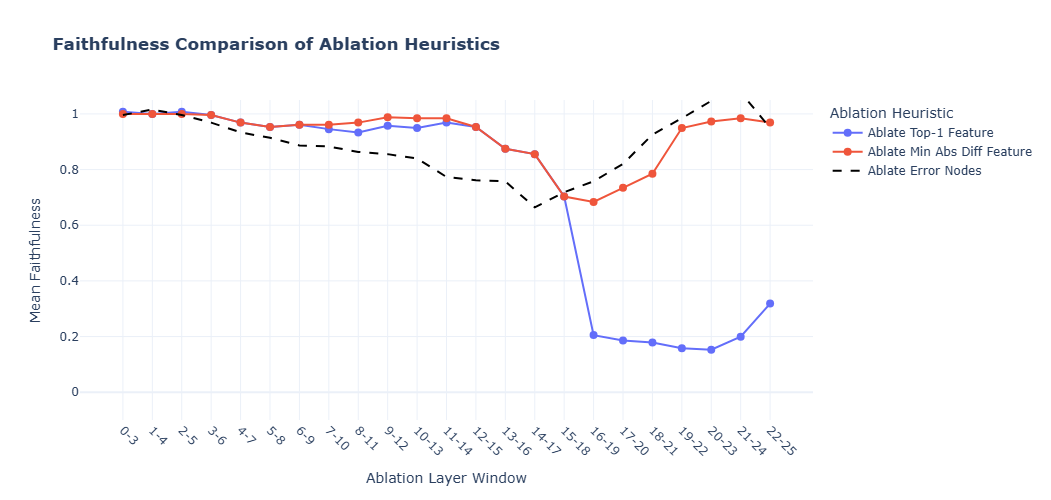


--- Displaying Ablated SFC Score Sum Comparison Plot ---


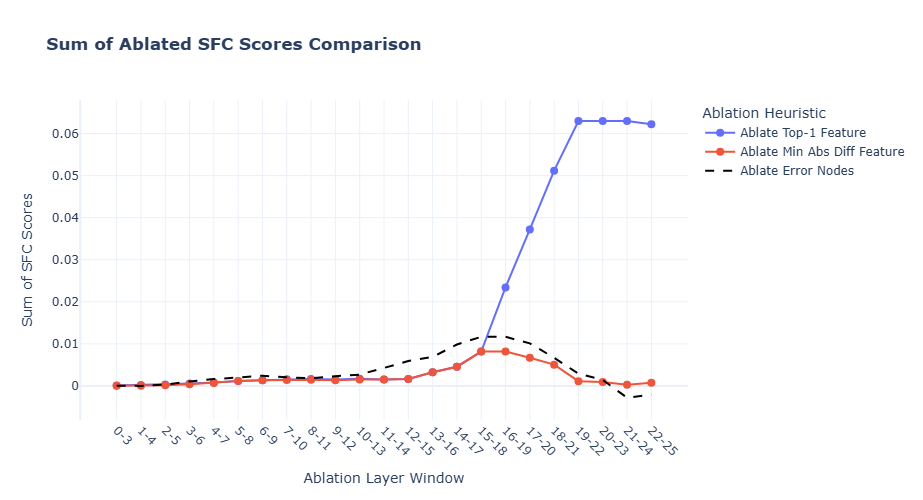

In [39]:
# ablate_errors_but_restore_features_GF_dataset.py

# --- NEW Plotting Function for Separate Faithfulness and Score Plots ---

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

def plot_multi_heuristic_ablation_separate(feature_results_dict, error_results_df):
    """
    Plots two separate graphs to compare sliding window ablation results:
    1. A graph comparing the Mean Faithfulness for each heuristic.
    2. A graph comparing the Sum of Ablated SFC Scores for each heuristic.
    
    Args:
        feature_results_dict: Dictionary where keys are heuristic names and values are result DataFrames.
        error_results_df: DataFrame with results from the error node ablation experiment.
    """
    # Create figures for each plot
    fig_faith = go.Figure()
    fig_scores = go.Figure()
    
    colors = px.colors.qualitative.Plotly
    
    heuristic_names = {
        'top_1': 'Ablate Top-1 Feature',
        'min_abs_diff': 'Ablate Min Abs Diff Feature',
        'committee_matching': 'Ablate "Committee" Feature(s)' # New name
    }
    
    last_df = None # To set the x-axis ticks later
    
    # --- 1. Add Traces for each Feature Selection Heuristic ---
    for i, (mode, df) in enumerate(feature_results_dict.items()):
        if df.empty: continue
        last_df = df
        color = colors[i % len(colors)]
        plot_name = heuristic_names.get(mode, mode)
        
        df['Window Label'] = df.apply(lambda r: f"{int(r['window_left'])}-{int(r['window_right'])}", axis=1)
        df['Window Midpoint'] = (df['window_left'] + df['window_right']) / 2
        
        # Add trace to Faithfulness plot
        fig_faith.add_trace(go.Scatter(
            x=df['Window Midpoint'], y=df['mean_faithfulness'], mode='lines+markers',
            name=plot_name, line=dict(color=color), marker=dict(size=8),
            hovertext=[f"Faithfulness: {m:.3f} ± {s:.3f}" for m,s in zip(df.mean_faithfulness, df.std_faithfulness)], hoverinfo='text+name'
        ))
        
        # Add trace to SFC Scores plot
        fig_scores.add_trace(go.Scatter(
            x=df['Window Midpoint'], y=df['sfc_score_sum'], mode='lines+markers',
            name=plot_name, line=dict(color=color), marker=dict(size=8),
            hovertext=[f"SFC Score Sum: {s:.2f}" for s in df.sfc_score_sum], hoverinfo='text+name'
        ))

    # --- 2. Add Traces for the Error Node Ablation Baseline ---
    if not error_results_df.empty:
        df_error = error_results_df
        df_error['Window Label'] = df_error.apply(lambda r: f"{int(r['window_left'])}-{int(r['window_right'])}", axis=1)
        df_error['Window Midpoint'] = (df_error['window_left'] + df_error['window_right']) / 2
        error_color = 'black'
        
        # Add to Faithfulness plot
        fig_faith.add_trace(go.Scatter(
            x=df_error['Window Midpoint'], y=df_error['mean_faithfulness'], mode='lines+markers',
            name='Ablate Error Nodes', line=dict(color=error_color, dash='dash'),
            marker=dict(symbol='x-thin', size=10, color=error_color),
            hovertext=[f"Faithfulness: {m:.3f} ± {s:.3f}" for m,s in zip(df_error.mean_faithfulness, df_error.std_faithfulness)], hoverinfo='text+name'
        ))

        # Add to SFC Scores plot
        fig_scores.add_trace(go.Scatter(
            x=df_error['Window Midpoint'], y=df_error['sfc_score_sum'], mode='lines+markers',
            name='Ablate Error Nodes', line=dict(color=error_color, dash='dash'),
            marker=dict(symbol='x-thin', size=10, color=error_color),
            hovertext=[f"SFC Score Sum: {s:.2f}" for s in df_error.sfc_score_sum], hoverinfo='text+name'
        ))
        
    # --- 3. Finalize Layouts for Both Plots ---
    xaxis_df = last_df if last_df is not None else (error_results_df if not error_results_df.empty else None)
    
    # Common layout settings
    common_layout = dict(hovermode='x unified', template='plotly_white', legend_title_text='Ablation Heuristic',
                        height=500)
    if xaxis_df is not None and not xaxis_df.empty:
        common_layout['xaxis'] = dict(
            title='Ablation Layer Window', tickmode='array',
            tickvals=xaxis_df['Window Midpoint'], ticktext=xaxis_df['Window Label'], tickangle=45
        )

    # Finalize Faithfulness Plot
    fig_faith.update_layout(title_text='<b>Faithfulness Comparison of Ablation Heuristics</b>', **common_layout)
    fig_faith.update_yaxes(title_text="Mean Faithfulness", range=[-0.1, 1.05])
    
    # Finalize SFC Scores Plot
    fig_scores.update_layout(title_text='<b>Sum of Ablated SFC Scores Comparison</b>', **common_layout)
    fig_scores.update_yaxes(title_text="Sum of SFC Scores")
    
    print("--- Displaying Faithfulness Comparison Plot ---")
    pio.write_image(fig_faith, "sliding_window_gf_full.png", format='png', scale=5, width=1000, height=500)
    fig_faith.show()
    
    print("\n--- Displaying Ablated SFC Score Sum Comparison Plot ---")
    pio.write_image(fig_scores, "sliding_window_gf_full_scores.png", format='png', scale=5, width=1000, height=500)
    fig_scores.show()


# --- Example Usage ---
# Assumes `all_feature_ablation_results` and `error_ablation_results_df` are available.
plot_multi_heuristic_ablation_separate(all_feature_ablation_results, error_ablation_results_df)

In [ ]:
# ablate_errors_but_restore_features_GF_dataset.py

# --- Save All Experimental Results to CSV ---

# --- Configuration for Saving ---
# Modify this suffix to version your output files. It will be appended to filenames.
# For example, 'v2', 'with_zero_ablation', etc.
SAVING_NAME_SUFFIX = 'GF_last_token_CM' 

# --- Prepare Suffix String ---
# Add a leading underscore to the suffix if it's not empty
suffix_str = f"_{SAVING_NAME_SUFFIX}" if SAVING_NAME_SUFFIX else ""

# --- 1. Save Feature Ablation Results ---
# This is a dictionary of DataFrames, so we loop through it.
print("\n--- Saving Feature Ablation Results ---")
if 'all_feature_ablation_results' in locals() and all_feature_ablation_results:
    for mode, df in all_feature_ablation_results.items():
        if isinstance(df, pd.DataFrame) and not df.empty:
            # Construct a descriptive filename including the mode
            filename = f"sliding_window_features_mode_{mode}{suffix_str}.csv"
            save_path = saving_dir / filename
            
            # Save the DataFrame to CSV
            df.to_csv(save_path, index=False)
            print(f"Saved results for mode '{mode}' to: {save_path}")
        else:
            print(f"No results to save for feature ablation mode '{mode}' (DataFrame is empty or not found).")
else:
    print("Variable 'all_feature_ablation_results' not found or is empty.")


# --- 2. Save Error Node Ablation Results ---
# This is a single DataFrame.
print("\n--- Saving Error Node Ablation Results ---")
if 'error_ablation_results_df' in locals() and isinstance(error_ablation_results_df, pd.DataFrame) and not error_ablation_results_df.empty:
    filename = f"sliding_window_errors{suffix_str}.csv"
    save_path = saving_dir / filename
    
    # Save the DataFrame to CSV
    error_ablation_results_df.to_csv(save_path, index=False)
    print(f"Saved error node ablation results to: {save_path}")
else:
    print("Variable 'error_ablation_results_df' not found or is empty. Nothing to save.")

## (Combined) Sliding window ablation plotting

In [117]:
# ablate_errors_but_restore_features_GF_dataset.py

# --- Helper Function to Load Experiment Results ---
import pandas as pd

def load_experiment_results(saving_dir, suffix, feature_modes):
    """
    Loads all result DataFrames for a given experiment suffix.
    
    Args:
        saving_dir: The Path object for the directory where results are saved.
        suffix: The string suffix of the experiment to load (e.g., 'GF').
        feature_modes: A list of the feature ablation modes that were run 
                       (e.g., ['top_1', 'min_abs_diff']).
                       
    Returns:
        A tuple containing:
        - A dictionary of feature ablation DataFrames.
        - The error node ablation DataFrame.
    """
    print(f"\n--- Loading results for suffix: '{suffix}' ---")
    suffix_str = f"_{suffix}" if suffix else ""
    
    # Load feature ablation results
    loaded_feature_results = {}
    for mode in feature_modes:
        filename = f"sliding_window_features_mode_{mode}{suffix_str}.csv"
        try:
            df = pd.read_csv(saving_dir / filename)
            loaded_feature_results[mode] = df
            print(f"  Successfully loaded: {filename}")
        except FileNotFoundError:
            print(f"  Warning: File not found, skipping: {filename}")
            
    # Load error node ablation results
    loaded_error_results_df = None
    filename = f"sliding_window_errors{suffix_str}.csv"
    try:
        loaded_error_results_df = pd.read_csv(saving_dir / filename)
        print(f"  Successfully loaded: {filename}")
    except FileNotFoundError:
        print(f"  Warning: File not found, skipping: {filename}")
        
    return loaded_feature_results, loaded_error_results_df

### Plot all the sliding window data

In [118]:
# --- Cell 1: Load and Consolidate All Experiment Data ---

# --- Configuration for Loading ---
# This should match the suffix you used when saving your multi-mode results
EXPERIMENT_SUFFIX = 'GF_last_token' 
MODES_TO_LOAD = ['top_1', 'min_abs_diff', 'committee_matching'] 

# --- Load Data from Files ---
loaded_feature_results, loaded_error_results_df = load_experiment_results(
    saving_dir, EXPERIMENT_SUFFIX, MODES_TO_LOAD
)

# --- Create a Master Dictionary for Plotting ---
all_plot_data = {}

# 1. Add the error node baseline data
if loaded_error_results_df is not None:
    all_plot_data['error_nodes'] = loaded_error_results_df
elif 'error_ablation_results_df' in locals() and error_ablation_results_df is not None:
    all_plot_data['error_nodes'] = error_ablation_results_df

# 2. Add the "heuristic" modes, renaming 'top_1' to 'fixed_top_1'
# Start with loaded results...
for mode, df in loaded_feature_results.items():
    if mode == 'top_1':
        all_plot_data['fixed_top_1'] = df # Unify the key
    else:
        all_plot_data[mode] = df
        
# ...then overwrite with any in-memory results
if 'all_feature_ablation_results' in locals():
    for mode, df in all_feature_ablation_results.items():
        if mode == 'top_1':
            all_plot_data['fixed_top_1'] = df # Unify the key
        else:
            all_plot_data[mode] = df

# 3. Add the results from the "fixed top-K" experiments
if 'feature_ablation_results_dict' in locals():
    for top_k, df in feature_ablation_results_dict.items():
        all_plot_data[f'fixed_top_{top_k}'] = df

print("\n--- Consolidated Data for Plotting (with Unified Keys) ---")
print(f"Plotting the following {len(all_plot_data)} data series: {list(all_plot_data.keys())}")


--- Loading results for suffix: 'GF_last_token' ---
  Successfully loaded: sliding_window_features_mode_top_1_GF_last_token.csv
  Successfully loaded: sliding_window_features_mode_min_abs_diff_GF_last_token.csv
  Successfully loaded: sliding_window_errors_GF_last_token.csv

--- Consolidated Data for Plotting (with Unified Keys) ---
Plotting the following 6 data series: ['error_nodes', 'fixed_top_1', 'min_abs_diff', 'committee_matching', 'fixed_top_5', 'fixed_top_10']


In [122]:
def plot_all_experiments_separate(all_results_dict, save_prefix="ablation_plot", save=True, ignore_modes=None):
    """
    Plots a comprehensive comparison of all ablation experiments, creating two separate plots:
    1. Mean Faithfulness vs. Ablation Window.
    2. Sum of Ablated AtP Scores vs. Ablation Window.

    Args:
        all_results_dict: Dict[str, pd.DataFrame]
            Keys are ablation modes, values are DataFrames with results.
        save_prefix: str
            Base filename for saved images (no extension).
        save: bool
            Whether to save the resulting plots to disk.
        ignore_modes: List[str]
            List of mode keys to skip when plotting.
    """
    if ignore_modes is None:
        ignore_modes = []

    fig_faith = go.Figure()
    fig_atp = go.Figure()
    
    colors = px.colors.qualitative.Plotly
    color_idx = 0
    last_df = None

    for mode, df in all_results_dict.items():
        if df.empty or mode in ignore_modes:
            continue
        last_df = df

        # --- Determine plot label and style ---
        is_fixed_k = isinstance(mode, str) and mode.startswith('fixed_top_')
        is_heuristic = mode in ['min_abs_diff', 'committee_matching']
        is_error = mode == 'error_nodes'

        if is_fixed_k:
            k_val = mode.split('_')[-1]
            plot_name = f'Ablate Fixed Top {k_val} Feature(s)'
            style = {'color': colors[color_idx % len(colors)], 'dash': 'solid'}
            color_idx += 1
        elif is_heuristic:
            heuristic_names = {
                'min_abs_diff': 'Ablate Min Abs Diff Feature',
                'committee_matching': 'Ablate "Committee" Feature(s)'
            }
            plot_name = heuristic_names.get(mode, mode)
            style = {'color': colors[color_idx % len(colors)], 'dash': 'dot'}
            color_idx += 1
        elif is_error:
            plot_name = 'Ablate Error Nodes (Baseline)'
            style = {'color': 'black', 'dash': 'dash'}
        else:
            plot_name = mode
            style = {'color': colors[color_idx % len(colors)], 'dash': 'solid'}
            color_idx += 1

        df['Window Label'] = df.apply(lambda r: f"{int(r['window_left'])}-{int(r['window_right'])}", axis=1)
        df['Window Midpoint'] = (df['window_left'] + df['window_right']) / 2

        # --- Add Faithfulness trace ---
        hover_faith = [
            f"Faithfulness: {m:.3f}" + (f" ± {s:.3f}" if not pd.isna(s) else "")
            for m, s in zip(df['mean_faithfulness'], df.get('std_faithfulness', np.nan))
        ]
        fig_faith.add_trace(go.Scatter(
            x=df['Window Midpoint'], y=df['mean_faithfulness'],
            mode='lines+markers',
            name=plot_name,
            legendgroup=mode,
            line=dict(color=style['color'], dash=style['dash']),
            marker=dict(symbol='circle' if not is_error else 'x-thin', size=8, color=style['color']),
            hovertext=hover_faith,
            hoverinfo='text+name'
        ))

        # --- Add AtP Score trace ---
        fig_atp.add_trace(go.Scatter(
            x=df['Window Midpoint'], y=df['sfc_score_sum'],
            mode='lines+markers',
            name=plot_name,
            legendgroup=mode,
            line=dict(color=style['color'], dash=style['dash']),
            marker=dict(symbol='circle' if not is_error else 'x-thin', size=8, color=style['color']),
            hovertext=[f"AtP Score Sum: {s:.2f}" for s in df['sfc_score_sum']],
            hoverinfo='text+name'
        ))

    # --- Axis label formatting ---
    if last_df is not None and not last_df.empty:
        x_tickvals = last_df['Window Midpoint']
        x_ticktext = last_df['Window Label']
    else:
        x_tickvals = []
        x_ticktext = []

    for fig in [fig_faith, fig_atp]:
        fig.update_layout(
            hovermode='x unified',
            template='plotly_white',
            legend_title_text='Ablation Strategy',
            xaxis=dict(
                title='Ablation Layer Window',
                tickmode='array',
                tickvals=x_tickvals,
                ticktext=x_ticktext,
                tickangle=45
            )
        )

    fig_faith.update_layout(
        title='Faithfulness across Feature Ablation windows',
        yaxis=dict(title="<b>Mean Faithfulness</b>", range=[-0.1, 1.05], dtick=0.1)
    )
    fig_atp.update_layout(
        title='Sum of AtP scores of the ablated features across Ablation windows',
        yaxis_title="<b>Sum of AtP Scores</b>"
    )

    print("\n--- Faithfulness Plot ---")
    fig_faith.show()
    print("\n--- Ablated AtP Score Sum Plot ---")
    fig_atp.show()

    if save:
        pio.write_image(fig_faith, f"{save_prefix}_faithfulness.png", format='png', scale=5, width=1000, height=500)
        pio.write_image(fig_atp, f"{save_prefix}_atp_score_sum.png", format='png', scale=5, width=1000, height=500)


--- Faithfulness Plot ---


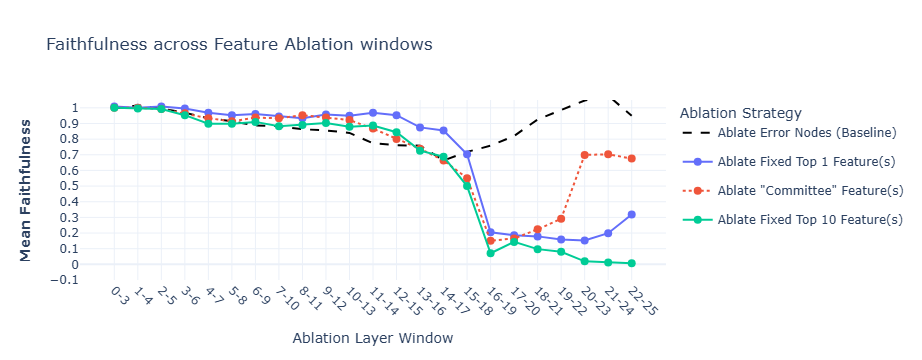


--- Ablated AtP Score Sum Plot ---


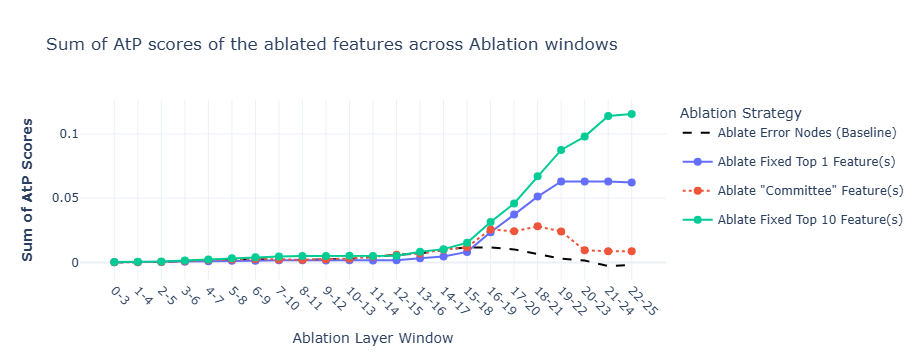

In [123]:
plot_all_experiments_separate(
    all_plot_data,
    ignore_modes=['min_abs_diff', 'fixed_top_5'],
    save_prefix="GF"
)

In [135]:
import pickle

def save_all_plot_data(all_plot_data, saving_dir, suffix):
    """
    Saves all_plot_data dictionary to a pickle file.
    
    Args:
        all_plot_data: dict[str, pd.DataFrame]
        saving_dir: Path object
        suffix: str (e.g. 'GF_last_token')
    """
    save_path = saving_dir / f"all_plot_data_{suffix}.pkl"
    with open(save_path, 'wb') as f:
        pickle.dump(all_plot_data, f)
    print(f"✅ Saved all_plot_data to {save_path}")

def load_all_plot_data(saving_dir, suffix):
    """
    Loads all_plot_data dictionary from a pickle file.
    
    Args:
        saving_dir: Path object
        suffix: str (e.g. 'GF_last_token')
        
    Returns:
        dict[str, pd.DataFrame]
    """
    load_path = saving_dir / f"all_plot_data_{suffix}.pkl"
    with open(load_path, 'rb') as f:
        data = pickle.load(f)
    print(f"✅ Loaded all_plot_data from {load_path}")
    return data

SAVING_SUFFIX = 'GF'
save_all_plot_data(all_plot_data, saving_dir, SAVING_SUFFIX)

✅ Saved all_plot_data to /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data/sva_rc_filtered/all_plot_data_GF.pkl


### Plot the difference between sliding window ablation data

In [139]:
def compute_plot_deltas(all_data_1, all_data_2):
    """
    Computes Δ mean_faithfulness between two all_plot_data dicts.
    
    Returns:
        diff_dict: dict[str, pd.DataFrame]
    """
    diff_dict = {}
    for key in all_data_1:
        if key not in all_data_2:
            print(f"⚠️ Key {key} not found in second dataset")
            continue
        df1, df2 = all_data_1[key].copy(), all_data_2[key].copy()
        if len(df1) != len(df2):
            print(f"⚠️ Length mismatch for mode {key}")
            continue
        diff_df = df1.copy()
        diff_df['mean_faithfulness'] = df1['mean_faithfulness'] - df2['mean_faithfulness']
        diff_df['Window Midpoint'] = (df1['window_left'] + df1['window_right']) / 2
        diff_df['Window Label'] = df1.apply(lambda r: f"{int(r['window_left'])}-{int(r['window_right'])}", axis=1)
        diff_dict[key] = diff_df
    return diff_dict


In [143]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

def plot_faithfulness_deltas(
    diff_dict,
    save_prefix="delta_faithfulness_plot",
    save=True,
    ignore_modes=None,
    title="Δ Faithfulness: Mean - Zero Ablation"
):
    """
    Plots the difference in mean faithfulness across ablation windows between
    two restoration conditions (e.g. mean vs zero).

    Args:
        diff_dict: Dict[str, pd.DataFrame]
            Dictionary mapping ablation mode → delta DataFrame.
        save_prefix: str
            Filename prefix to use when saving.
        save: bool
            Whether to save the figure as PNG.
        ignore_modes: list[str]
            List of ablation modes to skip from plotting.
        title: str
            Title of the plot.
    """
    if ignore_modes is None:
        ignore_modes = []

    fig = go.Figure()
    colors = px.colors.qualitative.Plotly
    color_idx = 0
    last_df = None

    for mode, df in diff_dict.items():
        if mode in ignore_modes or df.empty:
            continue
        last_df = df

        # --- Label & Style ---
        is_fixed_k = mode.startswith('fixed_top_')
        is_heuristic = mode in ['min_abs_diff', 'committee_matching']
        is_error = mode == 'error_nodes'

        if is_fixed_k:
            k_val = mode.split('_')[-1]
            plot_name = f'Delta: Fixed Top {k_val}'
            style = {'color': colors[color_idx % len(colors)], 'dash': 'solid'}
            color_idx += 1
        elif is_heuristic:
            label_map = {
                'min_abs_diff': 'Delta: Min Abs Diff',
                'committee_matching': 'Delta: Committee'
            }
            plot_name = label_map.get(mode, mode)
            style = {'color': colors[color_idx % len(colors)], 'dash': 'dot'}
            color_idx += 1
        elif is_error:
            plot_name = 'Delta: Error Nodes (Baseline)'
            style = {'color': 'black', 'dash': 'dash'}
        else:
            plot_name = f'Delta: {mode}'
            style = {'color': colors[color_idx % len(colors)], 'dash': 'solid'}
            color_idx += 1

        # --- Plot Trace ---
        fig.add_trace(go.Scatter(
            x=df['Window Midpoint'],
            y=df['mean_faithfulness'],
            mode='lines+markers',
            name=plot_name,
            legendgroup=mode,
            line=dict(color=style['color'], dash=style['dash']),
            marker=dict(symbol='circle' if not is_error else 'x-thin', size=8, color=style['color']),
            hovertext=[f"{plot_name}: Δ={v:.3f}" for v in df['mean_faithfulness']],
            hoverinfo='text+name'
        ))

    # --- Format axes based on last plotted df ---
    if last_df is not None and not last_df.empty:
        x_tickvals = last_df['Window Midpoint']
        x_ticktext = last_df['Window Label']
    else:
        x_tickvals = []
        x_ticktext = []

    fig.update_layout(
        title=title,
        xaxis=dict(
            title='Ablation Layer Window',
            tickmode='array',
            tickvals=x_tickvals,
            ticktext=x_ticktext,
            tickangle=45
        ),
        yaxis=dict(
            title="Δ Mean Faithfulness",
            zeroline=True,
            zerolinecolor='gray'
        ),
        template="plotly_white",
        width=1000,
        height=500,
        legend_title="Ablation Strategy",
        hovermode="x unified"
    )

    fig.show()

    if save:
        pio.write_image(fig, f"{save_prefix}_faithfulness_dif.png", format='png', scale=5, width=1000, height=500)

✅ Loaded all_plot_data from /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data/sva_rc_filtered/all_plot_data_GF.pkl
✅ Loaded all_plot_data from /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data/sva_rc_filtered/all_plot_data_GF_zerp.pkl


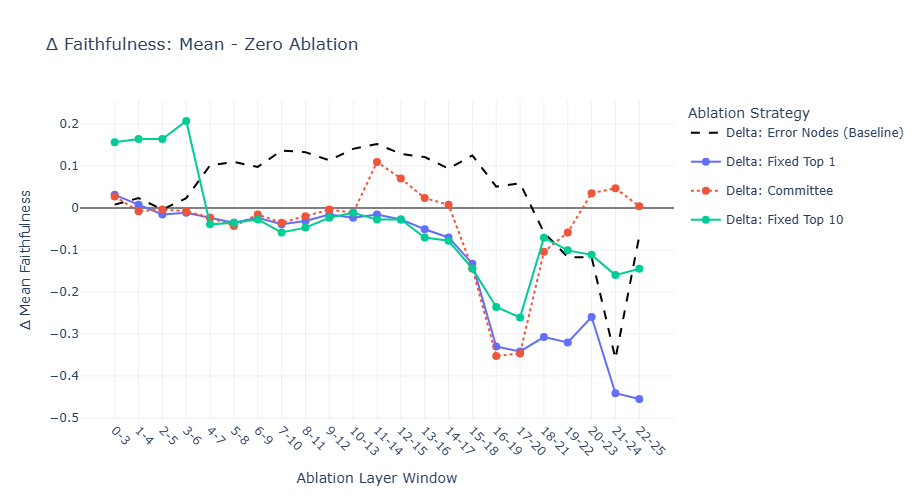

In [144]:
# MODES = ['fixed_top_1', 'fixed_top_5', 'committee_matching']

# === Load both versions ===
data_mean = load_all_plot_data(saving_dir, "GF")
data_zero = load_all_plot_data(saving_dir, "GF_zerp")

# Compute deltas and plot
delta_dict = compute_plot_deltas(data_mean, data_zero)
plot_faithfulness_deltas(delta_dict, 
                         ignore_modes=['fixed_top_5', 'min_abs_diff'])